## Function to calculate neural predictions for a single element

In [1]:
%pylab inline
import torch
from torch.autograd import Variable
from Chempy.parameter import ModelParameters
a = ModelParameters
a.neurons = 10 # 10 neurons
a.epochs = 1000
learning_rate = 0.01
element_index = 3

Populating the interactive namespace from numpy and matplotlib


In [2]:
def single_neural(lr,element_index,neurons=a.neurons):

    training_abundances = np.load('Neural/training_abundances.npy')
    tr_input = np.load('Neural/training_norm_grid.npy')
    tr_output = training_abundances[:,element_index]

    dim_in = tr_input.shape[1]
    dim_out = 1

    tr_input = Variable(torch.from_numpy(tr_input)).type(torch.FloatTensor)
    tr_output = Variable(torch.from_numpy(tr_output), requires_grad=False).type(torch.FloatTensor)

    model = []
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.Tanh(),
        torch.nn.Linear(neurons,dim_out)
        )
    loss_fn = torch.nn.L1Loss(size_average=True)


    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losslog = []
    epoch = []

    # Train neural network
    for i in range(a.epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer

        # Output loss
        if i % 3 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 100==0:
            print("Training epoch %d of %d complete" %(i,a.epochs))

    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())
        
    w_array_0=model_numpy[0]
    b_array_0=model_numpy[1]
    w_array_1=model_numpy[2]
    b_array_1=model_numpy[3]

    # Test network
    all_abun = np.load('Neural/verif_abundances.npy')
    test_abun = all_abun[:,element_index]
    test_param = np.load('Neural/verif_param_grid.npy')

    err = []
    for i,item in enumerate(test_param):
        norm_data = (item - a.p0)/np.array(a.training_widths)
        hidden1 = np.tanh(np.array(np.dot(w_array_0,norm_data)+b_array_0))
        output = np.dot(w_array_1, hidden1)+b_array_1
        err.append(np.absolute(output-test_abun[i]))
    print(np.median(err),max(err),min(err))
    return np.median(err),np.std(err),epoch,losslog,w_array_0,b_array_0,w_array_1,b_array_1

0.01
Training epoch 0 of 1000 complete
Training epoch 100 of 1000 complete
Training epoch 200 of 1000 complete
Training epoch 300 of 1000 complete
Training epoch 400 of 1000 complete
Training epoch 500 of 1000 complete
Training epoch 600 of 1000 complete
Training epoch 700 of 1000 complete
Training epoch 800 of 1000 complete
Training epoch 900 of 1000 complete
0.0201073950207 [ 0.63759841] [  4.06550307e-06]


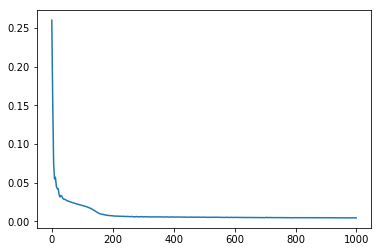

In [5]:
error = []
stderr = []
learning_rate = [0.01]
neurons = 10
for lr in learning_rate:
    print(lr)
    er,ste,epoch,losslog,w_array_0,b_array_0,w_array_1,b_array_1 = single_neural(lr,element_index,neurons)
    error.append(er)
    stderr.append(ste)
    plt.plot(epoch,losslog)

In [ ]:
plt.errorbar((learning_rate),error,yerr=stderr)


In [8]:
# Create random parameters up to 3 sigma from mean
from Chempy.cem_function import posterior_function_returning_predictions
err = []
sigma = np.array([0.3,0.3,0.3,0.3,0.1,0.1])
Ntest = 500
param = np.zeros((Ntest,len(a.p0)))
for i in range(Ntest):
    print(i)
    param[i,:] = a.p0+3*sigma*np.random.rand(6)
    rescaled_param = (param[i,:]-a.p0)/np.array(a.training_widths)
    hidden1 = np.tanh(np.array(np.dot(w_array_0,rescaled_param)+b_array_0))
    neural_output = np.dot(w_array_1, hidden1)+b_array_1
    abun,_= posterior_function_returning_predictions((param[i,:],a))
    chem_output = abun[element_index]
    err.append(np.absolute(chem_output-neural_output))


0


/home/philcox/anaconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


too few gas requested infall needed=  0.00806534894111 gas there =  1.47265557386e-05 total SFR =  [  8.29925537e-05   8.29925537e-03   1.54322980e-02   2.15220351e-02
   2.66798601e-02   3.10066636e-02   3.45937593e-02   3.75237320e-02
   3.98712130e-02   4.17035905e-02   4.30816585e-02   4.40602113e-02
   4.46885859e-02   4.50111589e-02   4.50677996e-02   4.48942844e-02
   4.45226754e-02   4.39816652e-02   4.32968926e-02] gas needed =  0.00808007541619 corona =  0.663647660935 sfe =  1.02712597905 dt =  0.5
too few gas requested infall needed=  0.0134678616835 gas there =  0.00155687571081 total SFR =  [  8.29925537e-05   8.29925537e-03   1.54322980e-02   2.15220351e-02
   2.66798601e-02   3.10066636e-02   3.45937593e-02   3.75237320e-02
   3.98712130e-02   4.17035905e-02   4.30816585e-02   4.40602113e-02
   4.46885859e-02   4.50111589e-02   4.50677996e-02   4.48942844e-02
   4.45226754e-02   4.39816652e-02   4.32968926e-02] gas needed =  0.0150247372596 corona =  0.673522655565 sfe 

too few gas requested infall needed=  0.0329388055367 gas there =  0.0092146340661 total SFR =  [  8.29925537e-05   8.29925537e-03   1.54322980e-02   2.15220351e-02
   2.66798601e-02   3.10066636e-02   3.45937593e-02   3.75237320e-02
   3.98712130e-02   4.17035905e-02   4.30816585e-02   4.40602113e-02
   4.46885859e-02   4.50111589e-02   4.50677996e-02   4.48942844e-02
   4.45226754e-02   4.39816652e-02   4.32968926e-02] gas needed =  0.0421534392735 corona =  1.03592248684 sfe =  1.02712597905 dt =  0.5
1


/home/philcox/Chempy/Chempy/wrapper.py:162: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']


2
3
too few gas requested infall needed=  0.0101660228389 gas there =  3.57772250159e-05 total SFR =  [ 0.00014471  0.01447149  0.0257768   0.03443548  0.04089127  0.04552254
  0.04865119  0.05055057  0.05145219  0.0515516   0.05101354  0.04997628
  0.04855549  0.04684748  0.0449321   0.04287516  0.04073055  0.03854207
  0.03634498] gas needed =  0.0102017999623 corona =  0.77778480078 sfe =  1.41852315185 dt =  0.5
too few gas requested infall needed=  0.0144457058459 gas there =  0.00372587059047 total SFR =  [ 0.00014471  0.01447149  0.0257768   0.03443548  0.04089127  0.04552254
  0.04865119  0.05055057  0.05145219  0.0515516   0.05101354  0.04997628
  0.04855549  0.04684748  0.0449321   0.04287516  0.04073055  0.03854207
  0.03634498] gas needed =  0.0181715762919 corona =  0.793770161555 sfe =  1.41852315185 dt =  0.5
too few gas requested infall needed=  0.0175682748866 gas there =  0.00670730799163 total SFR =  [ 0.00014471  0.01447149  0.0257768   0.03443548  0.04089127  0.045

too few gas requested infall needed=  0.0265254783619 gas there =  0.0147959836134 total SFR =  [ 0.00018646  0.01864633  0.0324817   0.04243707  0.04928328  0.05365684
  0.05608177  0.05698807  0.0567272   0.05558522  0.05379381  0.05153952
  0.04897161  0.04620851  0.04334331  0.04044835  0.03757898  0.03477678
  0.03207217] gas needed =  0.04132146171 corona =  0.910959465153 sfe =  1.19267994749 dt =  0.5
too few gas requested infall needed=  0.0277702674025 gas there =  0.0172181936353 total SFR =  [ 0.00018646  0.01864633  0.0324817   0.04243707  0.04928328  0.05365684
  0.05608177  0.05698807  0.0567272   0.05558522  0.05379381  0.05153952
  0.04897161  0.04620851  0.04334331  0.04044835  0.03757898  0.03477678
  0.03207217] gas needed =  0.0449884607602 corona =  0.947739379216 sfe =  1.19267994749 dt =  0.5
too few gas requested infall needed=  0.0282192840266 gas there =  0.0188023620808 total SFR =  [ 0.00018646  0.01864633  0.0324817   0.04243707  0.04928328  0.05365684
  0

too few gas requested infall needed=  0.029250695733 gas there =  0.00669387170939 total SFR =  [  9.34452564e-05   9.34452564e-03   1.72268274e-02   2.38185109e-02
   2.92732801e-02   3.37286880e-02   3.73077226e-02   4.01202448e-02
   4.22642890e-02   4.38272414e-02   4.48869061e-02   4.55124697e-02
   4.57653734e-02   4.57001012e-02   4.53648930e-02   4.48023878e-02
   4.40502046e-02   4.31414675e-02   4.21052785e-02] gas needed =  0.0359445671499 corona =  0.77321914896 sfe =  1.11616992578 dt =  0.5
too few gas requested infall needed=  0.0305942092126 gas there =  0.00727125229815 total SFR =  [  9.34452564e-05   9.34452564e-03   1.72268274e-02   2.38185109e-02
   2.92732801e-02   3.37286880e-02   3.73077226e-02   4.01202448e-02
   4.22642890e-02   4.38272414e-02   4.48869061e-02   4.55124697e-02
   4.57653734e-02   4.57001012e-02   4.53648930e-02   4.48023878e-02
   4.40502046e-02   4.31414675e-02   4.21052785e-02] gas needed =  0.0378654612048 corona =  0.791934861735 sfe =  1.

too few gas requested infall needed=  0.0185772973525 gas there =  0.00864782784367 total SFR =  [  9.03165600e-05   9.03165600e-03   1.66917493e-02   2.31364957e-02
   2.85062957e-02   3.29272353e-02   3.65124506e-02   3.93633671e-02
   4.15708262e-02   4.32161075e-02   4.43718572e-02   4.51029305e-02
   4.54671561e-02   4.55160290e-02   4.52953394e-02   4.48457416e-02
   4.42032704e-02   4.33998082e-02   4.24635073e-02] gas needed =  0.0272251250104 corona =  0.779997161979 sfe =  1.44584706568 dt =  0.5
too few gas requested infall needed=  0.0193353941048 gas there =  0.00941648947852 total SFR =  [  9.03165600e-05   9.03165600e-03   1.66917493e-02   2.31364957e-02
   2.85062957e-02   3.29272353e-02   3.65124506e-02   3.93633671e-02
   4.15708262e-02   4.32161075e-02   4.43718572e-02   4.51029305e-02
   4.54671561e-02   4.55160290e-02   4.52953394e-02   4.48457416e-02
   4.42032704e-02   4.33998082e-02   4.24635073e-02] gas needed =  0.02875188339 corona =  0.802862096986 sfe =  1.

too few gas requested infall needed=  0.0240703332286 gas there =  0.00780839835029 total SFR =  [ 0.00012441  0.01244087  0.02243634  0.03034689  0.03648581  0.04112492
  0.04449973  0.04681394  0.04824343  0.04893975  0.04903321  0.04863557
  0.04784248  0.04673549  0.04538398  0.04384669  0.0421732   0.04040514
  0.03857724] gas needed =  0.0318787313382 corona =  0.8538305201 sfe =  1.46850077581 dt =  0.5
too few gas requested infall needed=  0.0245485954298 gas there =  0.0083035719971 total SFR =  [ 0.00012441  0.01244087  0.02243634  0.03034689  0.03648581  0.04112492
  0.04449973  0.04681394  0.04824343  0.04893975  0.04903321  0.04863557
  0.04784248  0.04673549  0.04538398  0.04384669  0.0421732   0.04040514
  0.03857724] gas needed =  0.0328521671814 corona =  0.875916872771 sfe =  1.46850077581 dt =  0.5
too few gas requested infall needed=  0.0246614121752 gas there =  0.00866492604153 total SFR =  [ 0.00012441  0.01244087  0.02243634  0.03034689  0.03648581  0.04112492
 

too few gas requested infall needed=  0.0144196540819 gas there =  0.00748557100344 total SFR =  [  8.15994355e-05   8.15994355e-03   1.51916069e-02   2.12119959e-02
   2.63273311e-02   3.06339790e-02   3.42193078e-02   3.71624701e-02
   3.95351219e-02   4.14020807e-02   4.28219284e-02   4.38475639e-02
   4.45267086e-02   4.49023699e-02   4.50132644e-02   4.48942061e-02
   4.45764606e-02   4.40880696e-02   4.34541472e-02] gas needed =  0.0219052249411 corona =  0.790044306077 sfe =  1.9548728015 dt =  0.5
too few gas requested infall needed=  0.0145723444229 gas there =  0.00785753651292 total SFR =  [  8.15994355e-05   8.15994355e-03   1.51916069e-02   2.12119959e-02
   2.63273311e-02   3.06339790e-02   3.42193078e-02   3.71624701e-02
   3.95351219e-02   4.14020807e-02   4.28219284e-02   4.38475639e-02
   4.45267086e-02   4.49023699e-02   4.50132644e-02   4.48942061e-02
   4.45764606e-02   4.40880696e-02   4.34541472e-02] gas needed =  0.0224298807901 corona =  0.809038636242 sfe =  1

too few gas requested infall needed=  0.0198627758948 gas there =  0.0146676996455 total SFR =  [ 0.00016149  0.01614933  0.02849649  0.03771287  0.04436446  0.04892739
  0.05180124  0.05332045  0.05376413  0.05336445  0.05231382  0.05077103
  0.04886652  0.04670683  0.04437843  0.04195097  0.03948004  0.03700952
  0.03457354] gas needed =  0.0345304753416 corona =  1.17728198444 sfe =  1.41517068712 dt =  0.5
too few gas requested infall needed=  0.0188537274248 gas there =  0.014150649217 total SFR =  [ 0.00016149  0.01614933  0.02849649  0.03771287  0.04436446  0.04892739
  0.05180124  0.05332045  0.05376413  0.05336445  0.05231382  0.05077103
  0.04886652  0.04670683  0.04437843  0.04195097  0.03948004  0.03700952
  0.03457354] gas needed =  0.0330043764533 corona =  1.21181288735 sfe =  1.41517068712 dt =  0.5
too few gas requested infall needed=  0.0178117790151 gas there =  0.0135472846603 total SFR =  [ 0.00016149  0.01614933  0.02849649  0.03771287  0.04436446  0.04892739
  0.

too few gas requested infall needed=  0.0174922945727 gas there =  0.00943748879597 total SFR =  [ 0.00011279  0.01127895  0.02049884  0.02794161  0.03385485  0.03845578
  0.0419347   0.04445812  0.04617148  0.04720163  0.04765904  0.04763966
  0.04722674  0.04649228  0.04549841  0.04429862  0.04293878  0.04145809
  0.03988996] gas needed =  0.0269297831938 corona =  1.0480153647 sfe =  1.64496758311 dt =  0.5
too few gas requested infall needed=  0.0168291889013 gas there =  0.0092739250622 total SFR =  [ 0.00011279  0.01127895  0.02049884  0.02794161  0.03385485  0.03845578
  0.0419347   0.04445812  0.04617148  0.04720163  0.04765904  0.04763966
  0.04722674  0.04649228  0.04549841  0.04429862  0.04293878  0.04145809
  0.03988996] gas needed =  0.0261031137952 corona =  1.07214803047 sfe =  1.64496758311 dt =  0.5
too few gas requested infall needed=  0.0162262901375 gas there =  0.00897669563369 total SFR =  [ 0.00011279  0.01127895  0.02049884  0.02794161  0.03385485  0.03845578
  

too few gas requested infall needed=  0.019232605191 gas there =  0.0128107272772 total SFR =  [  9.83724471e-05   9.83724471e-03   1.80660621e-02   2.48836903e-02
   3.04658679e-02   3.49690309e-02   3.85322946e-02   4.12792399e-02
   4.33195232e-02   4.47503277e-02   4.56576694e-02   4.61175741e-02
   4.61971352e-02   4.59554666e-02   4.54445590e-02   4.47100490e-02
   4.37919111e-02   4.27250783e-02   4.15399988e-02] gas needed =  0.0320433322759 corona =  0.995288332382 sfe =  1.39529960873 dt =  0.5
too few gas requested infall needed=  0.0187333575456 gas there =  0.0126519529051 total SFR =  [  9.83724471e-05   9.83724471e-03   1.80660621e-02   2.48836903e-02
   3.04658679e-02   3.49690309e-02   3.85322946e-02   4.12792399e-02
   4.33195232e-02   4.47503277e-02   4.56576694e-02   4.61175741e-02
   4.61971352e-02   4.59554666e-02   4.54445590e-02   4.47100490e-02
   4.37919111e-02   4.27250783e-02   4.15399988e-02] gas needed =  0.0313853102634 corona =  1.01934459547 sfe =  1.39

too few gas requested infall needed=  0.0177802166813 gas there =  2.73658582945e-05 total SFR =  [ 0.00018178  0.01817756  0.03173897  0.04156343  0.04838129  0.05279767
  0.0553125   0.05633747  0.05621039  0.05520729  0.05355268  0.05142819
  0.04897981  0.04632404  0.04355304  0.04073887  0.03793717  0.03519016
  0.0325291 ] gas needed =  0.0178075823618 corona =  0.824362518455 sfe =  1.02077627678 dt =  0.5
too few gas requested infall needed=  0.0281719701569 gas there =  0.00292100354642 total SFR =  [ 0.00018178  0.01817756  0.03173897  0.04156343  0.04838129  0.05279767
  0.0553125   0.05633747  0.05621039  0.05520729  0.05355268  0.05142819
  0.04897981  0.04632404  0.04355304  0.04073887  0.03793717  0.03519016
  0.0325291 ] gas needed =  0.0310929734216 corona =  0.8421309764 sfe =  1.02077627678 dt =  0.5
too few gas requested infall needed=  0.035446457078 gas there =  0.0052710158911 total SFR =  [ 0.00018178  0.01817756  0.03173897  0.04156343  0.04838129  0.05279767
 

too few gas requested infall needed=  0.0297726388687 gas there =  0.00412208368183 total SFR =  [  9.80967416e-05   9.80967416e-03   1.80192106e-02   2.48243681e-02
   3.03996178e-02   3.49003128e-02   3.84646467e-02   4.12154192e-02
   4.32616273e-02   4.46999006e-02   4.56157932e-02   4.60849477e-02
   4.61741430e-02   4.59422365e-02   4.54410125e-02   4.47159442e-02
   4.38068790e-02   4.27486530e-02   4.15716442e-02] gas needed =  0.0338947222528 corona =  0.756635430388 sfe =  1.02966805596 dt =  0.5
too few gas requested infall needed=  0.0325471374355 gas there =  0.00480921916795 total SFR =  [  9.80967416e-05   9.80967416e-03   1.80192106e-02   2.48243681e-02
   3.03996178e-02   3.49003128e-02   3.84646467e-02   4.12154192e-02
   4.32616273e-02   4.46999006e-02   4.56157932e-02   4.60849477e-02
   4.61741430e-02   4.59422365e-02   4.54410125e-02   4.47159442e-02
   4.38068790e-02   4.27486530e-02   4.15716442e-02] gas needed =  0.037356356278 corona =  0.776163997341 sfe =  1

too few gas requested infall needed=  0.0238348783849 gas there =  0.00555142762968 total SFR =  [ 0.00013911  0.01391091  0.02486015  0.03332065  0.03969817  0.04434032
  0.0475443   0.04956369  0.05061438  0.05087973  0.05051503  0.04965142
  0.04839924  0.04685102  0.04508396  0.04316221  0.04113871  0.03905692
  0.03695217] gas needed =  0.0293863057762 corona =  0.849689410983 sfe =  1.50887709894 dt =  0.5
too few gas requested infall needed=  0.0252271748473 gas there =  0.00628254876863 total SFR =  [ 0.00013911  0.01391091  0.02486015  0.03332065  0.03969817  0.04434032
  0.0475443   0.04956369  0.05061438  0.05087973  0.05051503  0.04965142
  0.04839924  0.04685102  0.04508396  0.04316221  0.04113871  0.03905692
  0.03695217] gas needed =  0.0315097233637 corona =  0.874838012875 sfe =  1.50887709894 dt =  0.5
too few gas requested infall needed=  0.0260317984131 gas there =  0.0068162622769 total SFR =  [ 0.00013911  0.01391091  0.02486015  0.03332065  0.03969817  0.04434032

too few gas requested infall needed=  0.0250543696733 gas there =  0.00856688032406 total SFR =  [ 0.00011248  0.0112476   0.02044629  0.027876    0.03378266  0.03838208
  0.0418634   0.04439213  0.04611292  0.04715197  0.04761919  0.04761013
  0.04720768  0.04648357  0.04549973  0.04430949  0.0429586   0.04148621
  0.03992566] gas needed =  0.0336212497469 corona =  0.872292989187 sfe =  1.37154084088 dt =  0.5
too few gas requested infall needed=  0.0254483028216 gas there =  0.00893052569459 total SFR =  [ 0.00011248  0.0112476   0.02044629  0.027876    0.03378266  0.03838208
  0.0418634   0.04439213  0.04611292  0.04715197  0.04761919  0.04761013
  0.04720768  0.04648357  0.04549973  0.04430949  0.0429586   0.04148621
  0.03992566] gas needed =  0.0343788282617 corona =  0.899120871933 sfe =  1.37154084088 dt =  0.5
too few gas requested infall needed=  0.0255042690504 gas there =  0.00921521474841 total SFR =  [ 0.00011248  0.0112476   0.02044629  0.027876    0.03378266  0.0383820

too few gas requested infall needed=  0.0124253188134 gas there =  0.0106611087577 total SFR =  [  8.48343492e-05   8.48343492e-03   1.57499459e-02   2.19304559e-02
   2.71433680e-02   3.14956869e-02   3.50840456e-02   3.79956426e-02
   4.03090978e-02   4.20952349e-02   4.34177951e-02   4.43340887e-02
   4.48955901e-02   4.51484793e-02   4.51341375e-02   4.48895971e-02
   4.44479533e-02   4.38387380e-02   4.30882608e-02] gas needed =  0.0230864274469 corona =  0.903502819277 sfe =  1.92035293688 dt =  0.5
too few gas requested infall needed=  0.0124764352456 gas there =  0.0109023871899 total SFR =  [  8.48343492e-05   8.48343492e-03   1.57499459e-02   2.19304559e-02
   2.71433680e-02   3.14956869e-02   3.50840456e-02   3.79956426e-02
   4.03090978e-02   4.20952349e-02   4.34177951e-02   4.43340887e-02
   4.48955901e-02   4.51484793e-02   4.51341375e-02   4.48895971e-02
   4.44479533e-02   4.38387380e-02   4.30882608e-02] gas needed =  0.0233788223108 corona =  0.934880860763 sfe =  1.

too few gas requested infall needed=  0.02950598186 gas there =  0.0079943009801 total SFR =  [ 0.00013824  0.01382424  0.02471806  0.03314736  0.03951218  0.04415545
  0.04737059  0.04940818  0.05048172  0.05077266  0.05043485  0.04959829
  0.0483725   0.04684939  0.04510575  0.04320543  0.04120125  0.03913655
  0.03704669] gas needed =  0.037500282545 corona =  1.11503848709 sfe =  1.20281080501 dt =  0.5
too few gas requested infall needed=  0.0281779128145 gas there =  0.00774247762937 total SFR =  [ 0.00013824  0.01382424  0.02471806  0.03314736  0.03951218  0.04415545
  0.04737059  0.04940818  0.05048172  0.05077266  0.05043485  0.04959829
  0.0483725   0.04684939  0.04510575  0.04320543  0.04120125  0.03913655
  0.03704669] gas needed =  0.0359203901621 corona =  1.14106874208 sfe =  1.20281080501 dt =  0.5
too few gas requested infall needed=  0.0268249207965 gas there =  0.00742921808621 total SFR =  [ 0.00013824  0.01382424  0.02471806  0.03314736  0.03951218  0.04415545
  0.

too few gas requested infall needed=  0.0266724304784 gas there =  0.0106395941084 total SFR =  [  8.73570604e-05   8.73570604e-03   1.61840076e-02   2.24872008e-02
   2.77736015e-02   3.21588329e-02   3.57469992e-02   3.86317557e-02
   4.08972832e-02   4.26191759e-02   4.38652495e-02   4.46962775e-02
   4.51666605e-02   4.53250356e-02   4.52148301e-02   4.48747655e-02
   4.43393152e-02   4.36391202e-02   4.28013666e-02] gas needed =  0.0373120243201 corona =  1.03644736031 sfe =  1.20268911485 dt =  0.5
too few gas requested infall needed=  0.0262951369997 gas there =  0.0105716767027 total SFR =  [  8.73570604e-05   8.73570604e-03   1.61840076e-02   2.24872008e-02
   2.77736015e-02   3.21588329e-02   3.57469992e-02   3.86317557e-02
   4.08972832e-02   4.26191759e-02   4.38652495e-02   4.46962775e-02
   4.51666605e-02   4.53250356e-02   4.52148301e-02   4.48747655e-02
   4.43393152e-02   4.36391202e-02   4.28013666e-02] gas needed =  0.0368668134395 corona =  1.06728850677 sfe =  1.20

too few gas requested infall needed=  0.0258316897296 gas there =  0.00760182326968 total SFR =  [  8.24734761e-05   8.24734761e-03   1.53426592e-02   2.14066270e-02
   2.65487039e-02   3.08680845e-02   3.44546046e-02   3.73895643e-02
   3.97464820e-02   4.15917852e-02   4.29854420e-02   4.39815393e-02
   4.46288124e-02   4.49711280e-02   4.50479268e-02   4.48946278e-02
   4.45429979e-02   4.40214888e-02   4.33555454e-02] gas needed =  0.033433512741 corona =  0.986937114141 sfe =  1.33228590883 dt =  0.5
too few gas requested infall needed=  0.025472312216 gas there =  0.00756976143491 total SFR =  [  8.24734761e-05   8.24734761e-03   1.53426592e-02   2.14066270e-02
   2.65487039e-02   3.08680845e-02   3.44546046e-02   3.73895643e-02
   3.97464820e-02   4.15917852e-02   4.29854420e-02   4.39815393e-02
   4.46288124e-02   4.49711280e-02   4.50479268e-02   4.48946278e-02
   4.45429979e-02   4.40214888e-02   4.33555454e-02] gas needed =  0.0330420733962 corona =  1.01250319954 sfe =  1.3

76
77
78
79
too few gas requested infall needed=  0.0100017758251 gas there =  1.79717973835e-05 total SFR =  [ 0.00013949  0.01394906  0.02492267  0.03339685  0.03977992  0.04442153
  0.04762055  0.04963189  0.05067251  0.05092658  0.05055006  0.04967455
  0.04841079  0.04685154  0.04507422  0.04314307  0.04111113  0.03902186
  0.03691061] gas needed =  0.0100197475225 corona =  0.770212195325 sfe =  1.39215691367 dt =  0.5
too few gas requested infall needed=  0.0159645737509 gas there =  0.00193762649482 total SFR =  [ 0.00013949  0.01394906  0.02492267  0.03339685  0.03977992  0.04442153
  0.04762055  0.04963189  0.05067251  0.05092658  0.05055006  0.04967455
  0.04841079  0.04685154  0.04507422  0.04314307  0.04111113  0.03902186
  0.03691061] gas needed =  0.017902200086 corona =  0.786492260192 sfe =  1.39215691367 dt =  0.5
too few gas requested infall needed=  0.0204622005877 gas there =  0.00352708431706 total SFR =  [ 0.00013949  0.01394906  0.02492267  0.03339685  0.0397799

too few gas requested infall needed=  0.0190769224925 gas there =  0.00440825943697 total SFR =  [  9.58345764e-05   9.58345764e-03   1.76343099e-02   2.43363798e-02
   2.98538920e-02   3.43334319e-02   3.79057164e-02   4.06871945e-02
   4.27814932e-02   4.42807234e-02   4.52666592e-02   4.58118020e-02
   4.59803404e-02   4.58290163e-02   4.54079050e-02   4.47611189e-02
   4.39274410e-02   4.29408947e-02   4.18312574e-02] gas needed =  0.0234851817387 corona =  0.742837457423 sfe =  1.27117994437 dt =  0.5
too few gas requested infall needed=  0.0215731742567 gas there =  0.0054359304215 total SFR =  [  9.58345764e-05   9.58345764e-03   1.76343099e-02   2.43363798e-02
   2.98538920e-02   3.43334319e-02   3.79057164e-02   4.06871945e-02
   4.27814932e-02   4.42807234e-02   4.52666592e-02   4.58118020e-02
   4.59803404e-02   4.58290163e-02   4.54079050e-02   4.47611189e-02
   4.39274410e-02   4.29408947e-02   4.18312574e-02] gas needed =  0.0270091044625 corona =  0.766304723924 sfe =  1

too few gas requested infall needed=  0.00931383816382 gas there =  0.00688654533241 total SFR =  [  9.61194774e-05   9.61194774e-03   1.76828327e-02   2.43979612e-02
   2.99228334e-02   3.44051272e-02   3.79764928e-02   4.07541730e-02
   4.28424672e-02   4.43340530e-02   4.53111795e-02   4.58467435e-02
   4.60052605e-02   4.58437401e-02   4.54124743e-02   4.47557490e-02
   4.39124829e-02   4.29168041e-02   4.17985675e-02] gas needed =  0.0162003834031 corona =  0.742577997018 sfe =  1.84704476615 dt =  0.5
too few gas requested infall needed=  0.0101570419879 gas there =  0.0084700795768 total SFR =  [  9.61194774e-05   9.61194774e-03   1.76828327e-02   2.43979612e-02
   2.99228334e-02   3.44051272e-02   3.79764928e-02   4.07541730e-02
   4.28424672e-02   4.43340530e-02   4.53111795e-02   4.58467435e-02
   4.60052605e-02   4.58437401e-02   4.54124743e-02   4.47557490e-02
   4.39124829e-02   4.29168041e-02   4.17985675e-02] gas needed =  0.0186271214632 corona =  0.766321460047 sfe =  

too few gas requested infall needed=  0.0171108740547 gas there =  0.00709325919742 total SFR =  [  9.94958679e-05   9.94958679e-03   1.82568377e-02   2.51250727e-02
   3.07352378e-02   3.52482130e-02   3.88068922e-02   4.15380560e-02
   4.35540583e-02   4.49543440e-02   4.58268144e-02   4.62490555e-02
   4.62894417e-02   4.60081280e-02   4.54579409e-02   4.46851785e-02
   4.37303280e-02   4.26287096e-02   4.14110540e-02] gas needed =  0.024204133081 corona =  0.748119266887 sfe =  1.26983427506 dt =  0.5
too few gas requested infall needed=  0.0190314289421 gas there =  0.0087266918897 total SFR =  [  9.94958679e-05   9.94958679e-03   1.82568377e-02   2.51250727e-02
   3.07352378e-02   3.52482130e-02   3.88068922e-02   4.15380560e-02
   4.35540583e-02   4.49543440e-02   4.58268144e-02   4.62490555e-02
   4.62894417e-02   4.60081280e-02   4.54579409e-02   4.46851785e-02
   4.37303280e-02   4.26287096e-02   4.14110540e-02] gas needed =  0.0277581206415 corona =  0.770798614833 sfe =  1.

  0.03437105] gas needed =  0.03904800536 corona =  0.871590050504 sfe =  1.14631972955 dt =  0.5
too few gas requested infall needed=  0.0373693303184 gas there =  0.00564935484702 total SFR =  [ 0.00016346  0.01634556  0.02881231  0.03809058  0.0447615   0.04931317
  0.05215457  0.05362749  0.05401665  0.05355851  0.05244864  0.05084815
  0.04888909  0.04667908  0.04430526  0.0418376   0.03933179  0.03683163
  0.03437105] gas needed =  0.0430186847917 corona =  0.900180514498 sfe =  1.14631972955 dt =  0.5
too few gas requested infall needed=  0.0391879885151 gas there =  0.00630941783082 total SFR =  [ 0.00016346  0.01634556  0.02881231  0.03809058  0.0447615   0.04931317
  0.05215457  0.05362749  0.05401665  0.05355851  0.05244864  0.05084815
  0.04888909  0.04667908  0.04430526  0.0418376   0.03933179  0.03683163
  0.03437105] gas needed =  0.0454974059541 corona =  0.930254145502 sfe =  1.14631972955 dt =  0.5
too few gas requested infall needed=  0.0400791874296 gas there =  0.0

too few gas requested infall needed=  0.0218632150965 gas there =  0.0158381020197 total SFR =  [ 0.00016479  0.01647897  0.02902676  0.03834673  0.04503038  0.04957401
  0.05239306  0.0538343   0.0541863   0.05368841  0.05253836  0.05089881
  0.04890291  0.04665899  0.04425461  0.04175997  0.03923082  0.03671088
  0.03423394] gas needed =  0.0377013168976 corona =  0.989301717428 sfe =  1.43725223018 dt =  0.5
too few gas requested infall needed=  0.0213153664595 gas there =  0.0160395294934 total SFR =  [ 0.00016479  0.01647897  0.02902676  0.03834673  0.04503038  0.04957401
  0.05239306  0.0538343   0.0541863   0.05368841  0.05253836  0.05089881
  0.04890291  0.04665899  0.04425461  0.04175997  0.03923082  0.03671088
  0.03423394] gas needed =  0.0373548957397 corona =  1.02047194437 sfe =  1.43725223018 dt =  0.5
too few gas requested infall needed=  0.0205930769365 gas there =  0.0159616469204 total SFR =  [ 0.00016479  0.01647897  0.02902676  0.03834673  0.04503038  0.04957401
  

too few gas requested infall needed=  0.0186076185897 gas there =  0.00891405144709 total SFR =  [ 0.0001753   0.01753024  0.03070928  0.04034714  0.04711979  0.05158997
  0.05422486  0.05541114  0.0554678   0.05465694  0.05319302  0.05125063
  0.04897108  0.04646797  0.04383189  0.04113442  0.03843138  0.0357657
  0.03316975] gas needed =  0.0275216698507 corona =  1.077129719 sfe =  1.93276874249 dt =  0.5
too few gas requested infall needed=  0.0177887027972 gas there =  0.00872798946546 total SFR =  [ 0.0001753   0.01753024  0.03070928  0.04034714  0.04711979  0.05158997
  0.05422486  0.05541114  0.0554678   0.05465694  0.05319302  0.05125063
  0.04897108  0.04646797  0.04383189  0.04113442  0.03843138  0.0357657
  0.03316975] gas needed =  0.0265166920847 corona =  1.10704630796 sfe =  1.93276874249 dt =  0.5
too few gas requested infall needed=  0.0168547769897 gas there =  0.00848249123632 total SFR =  [ 0.0001753   0.01753024  0.03070928  0.04034714  0.04711979  0.05158997
  0.

too few gas requested infall needed=  0.0206761401407 gas there =  0.0135813702078 total SFR =  [ 0.00017076  0.0170765   0.02998466  0.03948761  0.04622427  0.05072832
  0.05344439  0.05474183  0.05492647  0.05425061  0.05292155  0.0511088
  0.04895022  0.04655724  0.04401921  0.04140721  0.03877708  0.03617216
  0.03362548] gas needed =  0.0342575101417 corona =  1.08648003424 sfe =  1.4288902141 dt =  0.5
too few gas requested infall needed=  0.0194662103392 gas there =  0.0131165838594 total SFR =  [ 0.00017076  0.0170765   0.02998466  0.03948761  0.04622427  0.05072832
  0.05344439  0.05474183  0.05492647  0.05425061  0.05292155  0.0511088
  0.04895022  0.04655724  0.04401921  0.04140721  0.03877708  0.03617216
  0.03362548] gas needed =  0.0325827940039 corona =  1.11067229974 sfe =  1.4288902141 dt =  0.5
too few gas requested infall needed=  0.0181561225182 gas there =  0.012650453399 total SFR =  [ 0.00017076  0.0170765   0.02998466  0.03948761  0.04622427  0.05072832
  0.0534

too few gas requested infall needed=  0.0266251230688 gas there =  0.0105752064175 total SFR =  [  8.53665227e-05   8.53665227e-03   1.58416101e-02   2.20481579e-02
   2.72767598e-02   3.16362155e-02   3.52247162e-02   3.81308095e-02
   4.04342791e-02   4.22069489e-02   4.35134163e-02   4.44117206e-02
   4.49539535e-02   4.51868150e-02   4.51521200e-02   4.48872606e-02
   4.44256262e-02   4.37969865e-02   4.30278400e-02] gas needed =  0.0372003292201 corona =  0.944992750148 sfe =  1.20842891655 dt =  0.5
too few gas requested infall needed=  0.0266765831364 gas there =  0.0107164440258 total SFR =  [  8.53665227e-05   8.53665227e-03   1.58416101e-02   2.20481579e-02
   2.72767598e-02   3.16362155e-02   3.52247162e-02   3.81308095e-02
   4.04342791e-02   4.22069489e-02   4.35134163e-02   4.44117206e-02
   4.49539535e-02   4.51868150e-02   4.51521200e-02   4.48872606e-02
   4.44256262e-02   4.37969865e-02   4.30278400e-02] gas needed =  0.0373930268955 corona =  0.977562418806 sfe =  1.

too few gas requested infall needed=  0.0174186512833 gas there =  0.0125672258179 total SFR =  [ 0.00018733  0.01873279  0.03261842  0.04259756  0.04944861  0.05381392
  0.05622202  0.05710627  0.05682066  0.0556531   0.05383657  0.05155854
  0.04896883  0.04618622  0.04330396  0.04039442  0.03751291  0.03470086
  0.03198853] gas needed =  0.029985876927 corona =  1.37667347194 sfe =  1.15724003248 dt =  0.5
too few gas requested infall needed=  0.0159582463579 gas there =  0.0116838448942 total SFR =  [ 0.00018733  0.01873279  0.03261842  0.04259756  0.04944861  0.05381392
  0.05622202  0.05710627  0.05682066  0.0556531   0.05383657  0.05155854
  0.04896883  0.04618622  0.04330396  0.04039442  0.03751291  0.03470086
  0.03198853] gas needed =  0.0276420910925 corona =  1.4007129359 sfe =  1.15724003248 dt =  0.5
105
106
107
108
too few gas requested infall needed=  0.00792188092912 gas there =  1.1255999289e-05 total SFR =  [  8.64105421e-05   8.64105421e-03   1.60212852e-02   2.2278

   4.43808987e-02   4.37145141e-02   4.29091454e-02] gas needed =  0.0393938186296 corona =  1.04276662977 sfe =  1.08923549144 dt =  0.5
109
110
too few gas requested infall needed=  0.00485227906413 gas there =  1.48315634957e-05 total SFR =  [  8.40141793e-05   8.40141793e-03   1.56085725e-02   2.17487874e-02
   2.69373201e-02   3.12784341e-02   3.48663793e-02   3.77862890e-02
   4.01149995e-02   4.19217995e-02   4.32691146e-02   4.42131336e-02
   4.48043787e-02   4.50882280e-02   4.51053912e-02   4.48923437e-02
   4.44817234e-02   4.39026915e-02   4.31812621e-02] gas needed =  0.0048671105791 corona =  0.66611767638 sfe =  1.72616130065 dt =  0.5
too few gas requested infall needed=  0.00747402235002 gas there =  0.00156833809533 total SFR =  [  8.40141793e-05   8.40141793e-03   1.56085725e-02   2.17487874e-02
   2.69373201e-02   3.12784341e-02   3.48663793e-02   3.77862890e-02
   4.01149995e-02   4.19217995e-02   4.32691146e-02   4.42131336e-02
   4.48043787e-02   4.50882280e-02  

too few gas requested infall needed=  0.0159757444539 gas there =  0.00904003034873 total SFR =  [  8.40141793e-05   8.40141793e-03   1.56085725e-02   2.17487874e-02
   2.69373201e-02   3.12784341e-02   3.48663793e-02   3.77862890e-02
   4.01149995e-02   4.19217995e-02   4.32691146e-02   4.42131336e-02
   4.48043787e-02   4.50882280e-02   4.51053912e-02   4.48923437e-02
   4.44817234e-02   4.39026915e-02   4.31812621e-02] gas needed =  0.0250157746429 corona =  1.04930287258 sfe =  1.72616130065 dt =  0.5
111
112
113
114
115
116
117
118
119
120
121
122
123
too few gas requested infall needed=  0.00674332643454 gas there =  2.59381903977e-05 total SFR =  [ 0.00011632  0.01163229  0.02109015  0.02867842  0.03466397  0.03928011
  0.04273053  0.04519281  0.04682154  0.04775101  0.04809771  0.04796246
  0.04743232  0.04658229  0.04547679  0.04417102  0.04271206  0.04113995
  0.0394886 ] gas needed =  0.0067692645575 corona =  0.732686195907 sfe =  1.71839794714 dt =  0.5
too few gas request

too few gas requested infall needed=  0.0169777873779 gas there =  0.00493464213593 total SFR =  [  9.24766892e-05   9.24766892e-03   1.70613637e-02   2.36078519e-02
   2.90366615e-02   3.34817514e-02   3.70630270e-02   3.98877140e-02
   4.20516041e-02   4.36401829e-02   4.47296526e-02   4.53878575e-02
   4.56751220e-02   4.56450088e-02   4.53450046e-02   4.48171408e-02
   4.40985533e-02   4.32219895e-02   4.22162652e-02] gas needed =  0.021912429344 corona =  0.735246341296 sfe =  1.32512288071 dt =  0.5
too few gas requested infall needed=  0.0191747291698 gas there =  0.00609217408614 total SFR =  [  9.24766892e-05   9.24766892e-03   1.70613637e-02   2.36078519e-02
   2.90366615e-02   3.34817514e-02   3.70630270e-02   3.98877140e-02
   4.20516041e-02   4.36401829e-02   4.47296526e-02   4.53878575e-02
   4.56751220e-02   4.56450088e-02   4.53450046e-02   4.48171408e-02
   4.40985533e-02   4.32219895e-02   4.22162652e-02] gas needed =  0.0252669030641 corona =  0.7589921205 sfe =  1.3

too few gas requested infall needed=  0.0221757868379 gas there =  0.00512874992858 total SFR =  [ 0.0001325   0.01325009  0.02377426  0.03199309  0.03826951  0.04291617
  0.04620194  0.04835762  0.04958096  0.05004093  0.04988166  0.04922566
  0.04817682  0.04682289  0.04523774  0.04348326  0.04161106  0.03966393
  0.03767709] gas needed =  0.0273045365447 corona =  0.807230486663 sfe =  1.40158076799 dt =  0.5
too few gas requested infall needed=  0.0243642575238 gas there =  0.00625557536757 total SFR =  [ 0.0001325   0.01325009  0.02377426  0.03199309  0.03826951  0.04291617
  0.04620194  0.04835762  0.04958096  0.05004093  0.04988166  0.04922566
  0.04817682  0.04682289  0.04523774  0.04348326  0.04161106  0.03966393
  0.03767709] gas needed =  0.0306198326477 corona =  0.826841764066 sfe =  1.40158076799 dt =  0.5
too few gas requested infall needed=  0.0258042525076 gas there =  0.0071599104581 total SFR =  [ 0.0001325   0.01325009  0.02377426  0.03199309  0.03826951  0.04291617

too few gas requested infall needed=  0.0437484422943 gas there =  0.0106048048933 total SFR =  [ 0.00018829  0.01882902  0.03277051  0.04277596  0.04963224  0.05398826
  0.05637752  0.05723717  0.05692401  0.05572799  0.05388356  0.05157917
  0.04896528  0.04616106  0.04325993  0.04033429  0.03743937  0.03461648
  0.03189568] gas needed =  0.0543532467501 corona =  1.04183590728 sfe =  1.05305882537 dt =  0.5
too few gas requested infall needed=  0.0432687258516 gas there =  0.0107871402552 total SFR =  [ 0.00018829  0.01882902  0.03277051  0.04277596  0.04963224  0.05398826
  0.05637752  0.05723717  0.05692401  0.05572799  0.05388356  0.05157917
  0.04896528  0.04616106  0.04325993  0.04033429  0.03743937  0.03461648
  0.03189568] gas needed =  0.0540558656741 corona =  1.08290792792 sfe =  1.05305882537 dt =  0.5
too few gas requested infall needed=  0.0421637358792 gas there =  0.0107563744471 total SFR =  [ 0.00018829  0.01882902  0.03277051  0.04277596  0.04963224  0.05398826
  0

too few gas requested infall needed=  0.0238113959304 gas there =  0.00996363603082 total SFR =  [ 0.00011046  0.01104648  0.02010879  0.02745421  0.03331805  0.03790718
  0.04140327  0.04396563  0.04573378  0.04682971  0.04735991  0.04741715
  0.0470821   0.04642478  0.04550576  0.04437736  0.0430846   0.0416661
  0.04015488] gas needed =  0.0337750317231 corona =  0.860320566761 sfe =  1.38651869661 dt =  0.5
too few gas requested infall needed=  0.023776499626 gas there =  0.0103809261008 total SFR =  [ 0.00011046  0.01104648  0.02010879  0.02745421  0.03331805  0.03790718
  0.04140327  0.04396563  0.04573378  0.04682971  0.04735991  0.04741715
  0.0470821   0.04642478  0.04550576  0.04437736  0.0430846   0.0416661
  0.04015488] gas needed =  0.034157425489 corona =  0.881795558759 sfe =  1.38651869661 dt =  0.5
too few gas requested infall needed=  0.0236769001872 gas there =  0.0105218071993 total SFR =  [ 0.00011046  0.01104648  0.02010879  0.02745421  0.03331805  0.03790718
  0.

too few gas requested infall needed=  0.0251994389764 gas there =  0.0150575920484 total SFR =  [  8.75663970e-05   8.75663970e-03   1.62199740e-02   2.25332632e-02
   2.78256619e-02   3.22135208e-02   3.58015737e-02   3.86840186e-02
   4.09455027e-02   4.26620193e-02   4.39017240e-02   4.47256785e-02
   4.51885260e-02   4.53391067e-02   4.52210164e-02   4.48731152e-02
   4.43299887e-02   4.36223680e-02   4.27775096e-02] gas needed =  0.0402570307728 corona =  0.94830440426 sfe =  1.12250022337 dt =  0.5
too few gas requested infall needed=  0.025159135483 gas there =  0.0152320431012 total SFR =  [  8.75663970e-05   8.75663970e-03   1.62199740e-02   2.25332632e-02
   2.78256619e-02   3.22135208e-02   3.58015737e-02   3.86840186e-02
   4.09455027e-02   4.26620193e-02   4.39017240e-02   4.47256785e-02
   4.51885260e-02   4.53391067e-02   4.52210164e-02   4.48731152e-02
   4.43299887e-02   4.36223680e-02   4.27775096e-02] gas needed =  0.0403911783326 corona =  0.980752614053 sfe =  1.12

too few gas requested infall needed=  0.0364452315668 gas there =  0.00659647509451 total SFR =  [ 0.00012398  0.01239752  0.02236439  0.03025803  0.03638914  0.04102742
  0.04440663  0.04672906  0.04816942  0.04887832  0.04898535  0.04860168
  0.04782249  0.04672902  0.04539038  0.04386513  0.04220273  0.04044472
  0.03862583] gas needed =  0.0430417062968 corona =  1.0838887482 sfe =  1.01913080827 dt =  0.5
too few gas requested infall needed=  0.0350004985692 gas there =  0.00641001342434 total SFR =  [ 0.00012398  0.01239752  0.02236439  0.03025803  0.03638914  0.04102742
  0.04440663  0.04672906  0.04816942  0.04887832  0.04898535  0.04860168
  0.04782249  0.04672902  0.04539038  0.04386513  0.04220273  0.04044472
  0.03862583] gas needed =  0.0414105116435 corona =  1.10771221852 sfe =  1.01913080827 dt =  0.5
too few gas requested infall needed=  0.0334807880573 gas there =  0.0062047188478 total SFR =  [ 0.00012398  0.01239752  0.02236439  0.03025803  0.03638914  0.04102742
  

too few gas requested infall needed=  0.0171358625014 gas there =  0.00636288761535 total SFR =  [  8.15244928e-05   8.15244928e-03   1.51786484e-02   2.11952899e-02
   2.63083190e-02   3.06138614e-02   3.41990749e-02   3.71429291e-02
   3.95169208e-02   4.13857300e-02   4.28078199e-02   4.38359877e-02
   4.45178681e-02   4.48963945e-02   4.50102214e-02   4.48941107e-02
   4.45792849e-02   4.40937501e-02   4.34625918e-02] gas needed =  0.0234987499454 corona =  0.923804920821 sfe =  1.91543045931 dt =  0.5
too few gas requested infall needed=  0.0170735269029 gas there =  0.00636460462375 total SFR =  [  8.15244928e-05   8.15244928e-03   1.51786484e-02   2.11952899e-02
   2.63083190e-02   3.06138614e-02   3.41990749e-02   3.71429291e-02
   3.95169208e-02   4.13857300e-02   4.28078199e-02   4.38359877e-02
   4.45178681e-02   4.48963945e-02   4.50102214e-02   4.48941107e-02
   4.45792849e-02   4.40937501e-02   4.34625918e-02] gas needed =  0.0234381313559 corona =  0.948865689289 sfe =  

too few gas requested infall needed=  0.0178661854936 gas there =  0.0145738181588 total SFR =  [  8.58368011e-05   8.58368011e-03   1.59225696e-02   2.21520564e-02
   2.73944395e-02   3.17601151e-02   3.53486594e-02   3.82498179e-02
   4.05444071e-02   4.23051375e-02   4.35973644e-02   4.44797723e-02
   4.50049984e-02   4.52202013e-02   4.51675787e-02   4.48848386e-02
   4.44056290e-02   4.37599280e-02   4.29743995e-02] gas needed =  0.0324400034737 corona =  0.935793113563 sfe =  1.38733025895 dt =  0.5
too few gas requested infall needed=  0.0178129226471 gas there =  0.0147822011809 total SFR =  [  8.58368011e-05   8.58368011e-03   1.59225696e-02   2.21520564e-02
   2.73944395e-02   3.17601151e-02   3.53486594e-02   3.82498179e-02
   4.05444071e-02   4.23051375e-02   4.35973644e-02   4.44797723e-02
   4.50049984e-02   4.52202013e-02   4.51675787e-02   4.48848386e-02
   4.44056290e-02   4.37599280e-02   4.29743995e-02] gas needed =  0.0325951236499 corona =  0.967412761526 sfe =  1.

too few gas requested infall needed=  0.0199671338633 gas there =  0.00926151916248 total SFR =  [ 0.0001904   0.01904028  0.03310401  0.04316672  0.05003399  0.05436913
  0.05671669  0.05752213  0.05714841  0.05588998  0.05398446  0.05162246
  0.04895584  0.04610456  0.04316243  0.04020188  0.03727798  0.03443171
  0.03169271] gas needed =  0.0292286528261 corona =  1.35895792397 sfe =  1.27539158283 dt =  0.5
too few gas requested infall needed=  0.0183882612948 gas there =  0.00860870795664 total SFR =  [ 0.0001904   0.01904028  0.03310401  0.04316672  0.05003399  0.05436913
  0.05671669  0.05752213  0.05714841  0.05588998  0.05398446  0.05162246
  0.04895584  0.04610456  0.04316243  0.04020188  0.03727798  0.03443171
  0.03169271] gas needed =  0.0269969690675 corona =  1.384382086 sfe =  1.27539158283 dt =  0.5
too few gas requested infall needed=  0.0168670125181 gas there =  0.00798238519568 total SFR =  [ 0.0001904   0.01904028  0.03310401  0.04316672  0.05003399  0.05436913
  

165
166
too few gas requested infall needed=  0.00568250597685 gas there =  2.77014027675e-05 total SFR =  [ 0.00011023  0.01102311  0.02006952  0.02740509  0.03326388  0.03785174
  0.04134948  0.0439157   0.04568932  0.04679185  0.04732936  0.04739432
  0.04706713  0.04641761  0.04550619  0.04438504  0.04309911  0.04168695
  0.04018155] gas needed =  0.00571020732279 corona =  0.721592180417 sfe =  1.93042183363 dt =  0.5
too few gas requested infall needed=  0.00751300120246 gas there =  0.00288344288872 total SFR =  [ 0.00011023  0.01102311  0.02006952  0.02740509  0.03326388  0.03785174
  0.04134948  0.0439157   0.04568932  0.04679185  0.04732936  0.04739432
  0.04706713  0.04641761  0.04550619  0.04438504  0.04309911  0.04168695
  0.04018155] gas needed =  0.010396444016 corona =  0.733747874405 sfe =  1.93042183363 dt =  0.5
too few gas requested infall needed=  0.00888139980904 gas there =  0.00531502635533 total SFR =  [ 0.00011023  0.01102311  0.02006952  0.02740509  0.0332638

too few gas requested infall needed=  0.0190121825429 gas there =  0.00836007235215 total SFR =  [ 0.00016139  0.01613867  0.02847933  0.03769232  0.04434284  0.04890636
  0.05178196  0.05330368  0.05375031  0.05335381  0.05230639  0.05076675
  0.04886521  0.04670827  0.04438236  0.0419571   0.03948808  0.03701919
  0.03458457] gas needed =  0.0273722547049 corona =  0.869161538944 sfe =  1.6199921419 dt =  0.5
too few gas requested infall needed=  0.0202709731926 gas there =  0.00991828706245 total SFR =  [ 0.00016139  0.01613867  0.02847933  0.03769232  0.04434284  0.04890636
  0.05178196  0.05330368  0.05375031  0.05335381  0.05230639  0.05076675
  0.04886521  0.04670827  0.04438236  0.0419571   0.03948808  0.03701919
  0.03458457] gas needed =  0.0301892600523 corona =  0.899184278414 sfe =  1.6199921419 dt =  0.5
too few gas requested infall needed=  0.0209514343556 gas there =  0.0110128952466 total SFR =  [ 0.00016139  0.01613867  0.02847933  0.03769232  0.04434284  0.04890636
 

too few gas requested infall needed=  0.0167626320111 gas there =  0.00721017706859 total SFR =  [ 0.00010577  0.01057667  0.01931793  0.02646266  0.0322221   0.03678285
  0.04030957  0.04294737  0.04482395  0.04605155  0.04672866  0.04694156
  0.04676573  0.046267    0.04550275  0.0445228   0.04337033  0.04208267
  0.04069194] gas needed =  0.0239728089121 corona =  0.835162594266 sfe =  1.79150350167 dt =  0.5
too few gas requested infall needed=  0.0172908949488 gas there =  0.00772940171655 total SFR =  [ 0.00010577  0.01057667  0.01931793  0.02646266  0.0322221   0.03678285
  0.04030957  0.04294737  0.04482395  0.04605155  0.04672866  0.04694156
  0.04676573  0.046267    0.04550275  0.0445228   0.04337033  0.04208267
  0.04069194] gas needed =  0.0250202964924 corona =  0.862261022541 sfe =  1.79150350167 dt =  0.5
too few gas requested infall needed=  0.0175939189599 gas there =  0.00811161079155 total SFR =  [ 0.00010577  0.01057667  0.01931793  0.02646266  0.0322221   0.0367828

too few gas requested infall needed=  0.0284964374576 gas there =  0.0102914391151 total SFR =  [  8.85294176e-05   8.85294176e-03   1.63853296e-02   2.27448994e-02
   2.80646956e-02   3.24644409e-02   3.60517834e-02   3.89234316e-02
   4.11661876e-02   4.28578865e-02   4.40682515e-02   4.48596710e-02
   4.52879043e-02   4.54027240e-02   4.52484985e-02   4.48647213e-02
   4.42864917e-02   4.35449499e-02   4.26676730e-02] gas needed =  0.0387878762877 corona =  0.891126177937 sfe =  1.13613468321 dt =  0.5
too few gas requested infall needed=  0.0289074836562 gas there =  0.0105769823815 total SFR =  [  8.85294176e-05   8.85294176e-03   1.63853296e-02   2.27448994e-02
   2.80646956e-02   3.24644409e-02   3.60517834e-02   3.89234316e-02
   4.11661876e-02   4.28578865e-02   4.40682515e-02   4.48596710e-02
   4.52879043e-02   4.54027240e-02   4.52484985e-02   4.48647213e-02
   4.42864917e-02   4.35449499e-02   4.26676730e-02] gas needed =  0.0394844657486 corona =  0.923132847416 sfe =  1.

too few gas requested infall needed=  0.0222961086879 gas there =  0.0112222573792 total SFR =  [ 0.00010417  0.01041735  0.01904895  0.02612438  0.03184699  0.0363967
  0.03993254  0.04259488  0.04450748  0.0457793   0.04650614  0.04677208
  0.04665078  0.04620667  0.04549598  0.04456767  0.04346426  0.04222259
  0.04087447] gas needed =  0.0335183658441 corona =  1.01688667828 sfe =  1.39179751432 dt =  0.5
too few gas requested infall needed=  0.021974365055 gas there =  0.0112249103582 total SFR =  [ 0.00010417  0.01041735  0.01904895  0.02612438  0.03184699  0.0363967
  0.03993254  0.04259488  0.04450748  0.0457793   0.04650614  0.04677208
  0.04665078  0.04620667  0.04549598  0.04456767  0.04346426  0.04222259
  0.04087447] gas needed =  0.0331992751935 corona =  1.05053528153 sfe =  1.39179751432 dt =  0.5
too few gas requested infall needed=  0.0215785354863 gas there =  0.0111101116958 total SFR =  [ 0.00010417  0.01041735  0.01904895  0.02612438  0.03184699  0.0363967
  0.039

too few gas requested infall needed=  0.0189018131663 gas there =  0.0114385332354 total SFR =  [ 0.00014812  0.01481165  0.02633103  0.035107    0.04160706  0.04622869
  0.04930914  0.05113388  0.05194398  0.05194244  0.05129965  0.05015816
  0.04863677  0.04683401  0.04483123  0.04269513  0.04048011  0.03823008
  0.03598018] gas needed =  0.0303403462127 corona =  1.11926265546 sfe =  1.40720658099 dt =  0.5
too few gas requested infall needed=  0.017782379881 gas there =  0.0109839073306 total SFR =  [ 0.00014812  0.01481165  0.02633103  0.035107    0.04160706  0.04622869
  0.04930914  0.05113388  0.05194398  0.05194244  0.05129965  0.05015816
  0.04863677  0.04683401  0.04483123  0.04269513  0.04048011  0.03823008
  0.03598018] gas needed =  0.0287662870338 corona =  1.14123123154 sfe =  1.40720658099 dt =  0.5
too few gas requested infall needed=  0.0166683044891 gas there =  0.0104990471939 total SFR =  [ 0.00014812  0.01481165  0.02633103  0.035107    0.04160706  0.04622869
  0.

179
180
too few gas requested infall needed=  0.00476011720326 gas there =  8.99128630049e-06 total SFR =  [  9.11326193e-05   9.11326193e-03   1.68314799e-02   2.33148172e-02
   2.87070922e-02   3.31373420e-02   3.67212427e-02   3.95623984e-02
   4.17535121e-02   4.33774470e-02   4.45081899e-02   4.52117243e-02
   4.55468225e-02   4.55657627e-02   4.53149787e-02   4.48356487e-02
   4.41642271e-02   4.33329271e-02   4.23701560e-02] gas needed =  0.00476910844196 corona =  0.682603614877 sfe =  1.91089425614 dt =  0.5
too few gas requested infall needed=  0.00781734761842 gas there =  0.000990821619765 total SFR =  [  9.11326193e-05   9.11326193e-03   1.68314799e-02   2.33148172e-02
   2.87070922e-02   3.31373420e-02   3.67212427e-02   3.95623984e-02
   4.17535121e-02   4.33774470e-02   4.45081899e-02   4.52117243e-02
   4.55468225e-02   4.55657627e-02   4.53149787e-02   4.48356487e-02
   4.41642271e-02   4.33329271e-02   4.23701560e-02] gas needed =  0.00880816916001 corona =  0.693260

182
183
184
185
186
187
188
too few gas requested infall needed=  0.0099577991933 gas there =  1.69077151384e-05 total SFR =  [ 0.00010039  0.01003852  0.01840771  0.02531578  0.03094782  0.03546829
  0.03902309  0.04174155  0.04373817  0.0451142   0.04595904  0.0463515
  0.04636096  0.04604842  0.04546734  0.04466454  0.04368092  0.04255208
  0.04130899] gas needed =  0.00997470680886 corona =  0.702345173205 sfe =  1.00639754102 dt =  0.5
too few gas requested infall needed=  0.0164973890861 gas there =  0.00179330875122 total SFR =  [ 0.00010039  0.01003852  0.01840771  0.02531578  0.03094782  0.03546829
  0.03902309  0.04174155  0.04373817  0.0451142   0.04595904  0.0463515
  0.04636096  0.04604842  0.04546734  0.04466454  0.04368092  0.04255208
  0.04130899] gas needed =  0.0182906976723 corona =  0.712368656718 sfe =  1.00639754102 dt =  0.5
too few gas requested infall needed=  0.0217450400162 gas there =  0.00340980643528 total SFR =  [ 0.00010039  0.01003852  0.01840771  0.025

too few gas requested infall needed=  0.0121459487044 gas there =  0.00353830982788 total SFR =  [  8.96150851e-05   8.96150851e-03   1.65715440e-02   2.29829667e-02
   2.83332687e-02   3.27460221e-02   3.63321963e-02   3.91913567e-02
   4.14127528e-02   4.30763085e-02   4.42535205e-02   4.50082748e-02
   4.53975885e-02   4.54722816e-02   4.52775882e-02   4.48537093e-02
   4.42363152e-02   4.34569997e-02   4.25436922e-02] gas needed =  0.0156842584108 corona =  0.714284705106 sfe =  1.80647806232 dt =  0.5
too few gas requested infall needed=  0.0136890240838 gas there =  0.00443797285048 total SFR =  [  8.96150851e-05   8.96150851e-03   1.65715440e-02   2.29829667e-02
   2.83332687e-02   3.27460221e-02   3.63321963e-02   3.91913567e-02
   4.14127528e-02   4.30763085e-02   4.42535205e-02   4.50082748e-02
   4.53975885e-02   4.54722816e-02   4.52775882e-02   4.48537093e-02
   4.42363152e-02   4.34569997e-02   4.25436922e-02] gas needed =  0.0181269967974 corona =  0.729541188813 sfe =  

too few gas requested infall needed=  0.0197481868856 gas there =  0.00764583753611 total SFR =  [ 0.00018006  0.01800639  0.03146715  0.04124293  0.04804953  0.05248074
  0.05502779  0.05609572  0.05601734  0.05506503  0.05346065  0.05138398
  0.04897982  0.04636391  0.04362803  0.04084413  0.03806793  0.03534183
  0.03269742] gas needed =  0.0273940242242 corona =  0.8823251257 sfe =  1.75401492776 dt =  0.5
too few gas requested infall needed=  0.0208558525105 gas there =  0.00906449945001 total SFR =  [ 0.00018006  0.01800639  0.03146715  0.04124293  0.04804953  0.05248074
  0.05502779  0.05609572  0.05601734  0.05506503  0.05346065  0.05138398
  0.04897982  0.04636391  0.04362803  0.04084413  0.03806793  0.03534183
  0.03269742] gas needed =  0.029920351752 corona =  0.906040295288 sfe =  1.75401492776 dt =  0.5
too few gas requested infall needed=  0.0212848971075 gas there =  0.0100875785024 total SFR =  [ 0.00018006  0.01800639  0.03146715  0.04124293  0.04804953  0.05248074
  

too few gas requested infall needed=  0.031853756745 gas there =  0.0115623867209 total SFR =  [ 0.00015693  0.01569343  0.02776096  0.03683089  0.04343476  0.04802131
  0.05096849  0.05259386  0.05316349  0.05289962  0.05198722  0.05057964
  0.04880349  0.04676269  0.0445421   0.04221049  0.03982316  0.03742408
  0.03504784] gas needed =  0.0434161431474 corona =  0.914337892666 sfe =  1.21138951226 dt =  0.5
too few gas requested infall needed=  0.0317453845944 gas there =  0.012140990409 total SFR =  [ 0.00015693  0.01569343  0.02776096  0.03683089  0.04343476  0.04802131
  0.05096849  0.05259386  0.05316349  0.05289962  0.05198722  0.05057964
  0.04880349  0.04676269  0.0445421   0.04221049  0.03982316  0.03742408
  0.03504784] gas needed =  0.0438863746859 corona =  0.937930360257 sfe =  1.21138951226 dt =  0.5
too few gas requested infall needed=  0.0312603999054 gas there =  0.0124081480649 total SFR =  [ 0.00015693  0.01569343  0.02776096  0.03683089  0.04343476  0.04802131
  0

too few gas requested infall needed=  0.0252599732786 gas there =  0.00588682004599 total SFR =  [  8.15354239e-05   8.15354239e-03   1.51805386e-02   2.11977268e-02
   2.63110924e-02   3.06167962e-02   3.42020267e-02   3.71457800e-02
   3.95195764e-02   4.13881157e-02   4.28098787e-02   4.38376771e-02
   4.45191584e-02   4.48972668e-02   4.50106660e-02   4.48941252e-02
   4.45788734e-02   4.40929219e-02   4.34613602e-02] gas needed =  0.031146793072 corona =  0.751290364881 sfe =  1.26881686724 dt =  0.5
too few gas requested infall needed=  0.0262391997589 gas there =  0.00638025631939 total SFR =  [  8.15354239e-05   8.15354239e-03   1.51805386e-02   2.11977268e-02
   2.63110924e-02   3.06167962e-02   3.42020267e-02   3.71457800e-02
   3.95195764e-02   4.13881157e-02   4.28098787e-02   4.38376771e-02
   4.45191584e-02   4.48972668e-02   4.50106660e-02   4.48941252e-02
   4.45788734e-02   4.40929219e-02   4.34613602e-02] gas needed =  0.0326194558158 corona =  0.768638340599 sfe =  1

too few gas requested infall needed=  0.0205521456672 gas there =  0.0142711739561 total SFR =  [ 0.00015168  0.01516845  0.0269108   0.03580745  0.04235139  0.04696054
  0.04998847  0.05173353  0.05244687  0.05233926  0.05158704  0.05033717
  0.04871165  0.04681127  0.04471885  0.04250199  0.0402155   0.03790338
  0.03560058] gas needed =  0.0348233194178 corona =  0.993976707241 sfe =  1.50608476473 dt =  0.5
too few gas requested infall needed=  0.0202552836422 gas there =  0.0144965866595 total SFR =  [ 0.00015168  0.01516845  0.0269108   0.03580745  0.04235139  0.04696054
  0.04998847  0.05173353  0.05244687  0.05233926  0.05158704  0.05033717
  0.04871165  0.04681127  0.04471885  0.04250199  0.0402155   0.03790338
  0.03560058] gas needed =  0.0347518700992 corona =  1.02990831071 sfe =  1.50608476473 dt =  0.5
too few gas requested infall needed=  0.0197450112689 gas there =  0.0145074011535 total SFR =  [ 0.00015168  0.01516845  0.0269108   0.03580745  0.04235139  0.04696054
  

too few gas requested infall needed=  0.0384474765292 gas there =  0.00577525952494 total SFR =  [ 0.00011662  0.01166236  0.02114038  0.02874091  0.03473246  0.03934974
  0.04279761  0.04525459  0.04687604  0.0477969   0.04813418  0.0479891
  0.04744904  0.04658927  0.0454744   0.04415974  0.0426925   0.04111278
  0.03945452] gas needed =  0.0442227356696 corona =  0.974745838357 sfe =  1.07295589288 dt =  0.5
too few gas requested infall needed=  0.0376669199842 gas there =  0.00575450277417 total SFR =  [ 0.00011662  0.01166236  0.02114038  0.02874091  0.03473246  0.03934974
  0.04279761  0.04525459  0.04687604  0.0477969   0.04813418  0.0479891
  0.04744904  0.04658927  0.0454744   0.04415974  0.0426925   0.04111278
  0.03945452] gas needed =  0.0434214223817 corona =  0.999261039269 sfe =  1.07295589288 dt =  0.5
too few gas requested infall needed=  0.0367082245542 gas there =  0.00567412874446 total SFR =  [ 0.00011662  0.01166236  0.02114038  0.02874091  0.03473246  0.03934974


too few gas requested infall needed=  0.0271038396462 gas there =  0.0111163337763 total SFR =  [ 0.00010904  0.01090443  0.01987003  0.02715535  0.03298827  0.03756947
  0.0410754   0.04366104  0.04546231  0.04659823  0.04717288  0.04727707
  0.04698991  0.04638016  0.04550744  0.04442333  0.04317231  0.04179263
  0.04031705] gas needed =  0.0382201731515 corona =  0.98831001896 sfe =  1.16230047238 dt =  0.5
too few gas requested infall needed=  0.0261249206166 gas there =  0.0110189239638 total SFR =  [ 0.00010904  0.01090443  0.01987003  0.02715535  0.03298827  0.03756947
  0.0410754   0.04366104  0.04546231  0.04659823  0.04717288  0.04727707
  0.04698991  0.04638016  0.04550744  0.04442333  0.04317231  0.04179263
  0.04031705] gas needed =  0.0371438443191 corona =  1.00884592799 sfe =  1.16230047238 dt =  0.5
too few gas requested infall needed=  0.0252416096645 gas there =  0.0107152097337 total SFR =  [ 0.00010904  0.01090443  0.01987003  0.02715535  0.03298827  0.03756947
  0

too few gas requested infall needed=  0.0287676213718 gas there =  0.00476614068727 total SFR =  [ 0.00014078  0.01407793  0.02513369  0.03365387  0.04005542  0.04469499
  0.04787708  0.04986112  0.05086763  0.05108361  0.05066717  0.04975158
  0.04844879  0.04685248  0.04504067  0.04307801  0.04101775  0.03890347
  0.0367705 ] gas needed =  0.0335337617714 corona =  1.13671368041 sfe =  1.09652164107 dt =  0.5
220
221
222
223
224
too few gas requested infall needed=  0.00569321626213 gas there =  1.93488411003e-05 total SFR =  [  9.96157140e-05   9.96157140e-03   1.82771771e-02   2.51507913e-02
   3.07639193e-02   3.52779183e-02   3.88360873e-02   4.15655500e-02
   4.35789490e-02   4.49759710e-02   4.58447187e-02   4.62629444e-02
   4.62991592e-02   4.60136287e-02   4.54592683e-02   4.46824458e-02
   4.37237029e-02   4.26184005e-02   4.13972987e-02] gas needed =  0.00571256504629 corona =  0.700772392602 sfe =  1.74380008285 dt =  0.5
too few gas requested infall needed=  0.0084442933

too few gas requested infall needed=  0.0132802796193 gas there =  0.0104594250468 total SFR =  [  9.96157140e-05   9.96157140e-03   1.82771771e-02   2.51507913e-02
   3.07639193e-02   3.52779183e-02   3.88360873e-02   4.15655500e-02
   4.35789490e-02   4.49759710e-02   4.58447187e-02   4.62629444e-02
   4.62991592e-02   4.60136287e-02   4.54592683e-02   4.46824458e-02
   4.37237029e-02   4.26184005e-02   4.13972987e-02] gas needed =  0.0237397045334 corona =  1.03033244019 sfe =  1.74380008285 dt =  0.5
225
too few gas requested infall needed=  0.00824870633093 gas there =  3.73793481133e-05 total SFR =  [ 0.00015537  0.01553667  0.02750745  0.03652616  0.04311271  0.04770653
  0.05067824  0.05233965  0.05295235  0.05273516  0.05187048  0.05050977
  0.04877828  0.04677901  0.04459624  0.0422984   0.03994065  0.03756701
  0.03521216] gas needed =  0.00828608559656 corona =  0.792397920083 sfe =  1.87503078555 dt =  0.5
too few gas requested infall needed=  0.0107742397781 gas there =  

  0.0399378 ] gas needed =  0.0324399784591 corona =  0.765494379796 sfe =  1.04063211178 dt =  0.5
too few gas requested infall needed=  0.0320293954352 gas there =  0.0048299212018 total SFR =  [ 0.00011237  0.01123693  0.0204284   0.02785366  0.03375808  0.03835699
  0.04183911  0.04436964  0.04609296  0.04713503  0.0476056   0.04760005
  0.04720116  0.04648057  0.04550016  0.04431317  0.04296534  0.04149577
  0.0399378 ] gas needed =  0.0368593163167 corona =  0.781908463812 sfe =  1.04063211178 dt =  0.5
too few gas requested infall needed=  0.0345819620506 gas there =  0.00562351602095 total SFR =  [ 0.00011237  0.01123693  0.0204284   0.02785366  0.03375808  0.03835699
  0.04183911  0.04436964  0.04609296  0.04713503  0.0476056   0.04760005
  0.04720116  0.04648057  0.04550016  0.04431317  0.04296534  0.04149577
  0.0399378 ] gas needed =  0.0402054777257 corona =  0.799470637482 sfe =  1.04063211178 dt =  0.5
too few gas requested infall needed=  0.036399693909 gas there =  0.0

too few gas requested infall needed=  0.0248228288926 gas there =  0.00993116344191 total SFR =  [ 0.00018172  0.01817207  0.03173027  0.04155317  0.04837068  0.05278754
  0.05530341  0.05632976  0.05620424  0.05520277  0.05354977  0.0514268
  0.04897983  0.04632534  0.04355545  0.04074225  0.03794136  0.03519501
  0.03253448] gas needed =  0.0347539920863 corona =  0.99305622812 sfe =  1.62081415691 dt =  0.5
too few gas requested infall needed=  0.0245164915184 gas there =  0.0101600582366 total SFR =  [ 0.00018172  0.01817207  0.03173027  0.04155317  0.04837068  0.05278754
  0.05530341  0.05632976  0.05620424  0.05520277  0.05354977  0.0514268
  0.04897983  0.04632534  0.04355545  0.04074225  0.03794136  0.03519501
  0.03253448] gas needed =  0.0346765495099 corona =  1.02554266424 sfe =  1.62081415691 dt =  0.5
too few gas requested infall needed=  0.0237978568475 gas there =  0.0102608091476 total SFR =  [ 0.00018172  0.01817207  0.03173027  0.04155317  0.04837068  0.05278754
  0.

too few gas requested infall needed=  0.0235953674025 gas there =  0.00732231599185 total SFR =  [ 0.00010074  0.01007376  0.01846746  0.02539124  0.03103189  0.03555526
  0.03910846  0.04182184  0.04381075  0.04517715  0.04601102  0.04639169
  0.04638893  0.04606404  0.04547077  0.04465614  0.04366118  0.04252164
  0.04126855] gas needed =  0.0309176831584 corona =  0.912439860747 sfe =  1.48817819959 dt =  0.5
too few gas requested infall needed=  0.0236767162278 gas there =  0.00749675990564 total SFR =  [ 0.00010074  0.01007376  0.01846746  0.02539124  0.03103189  0.03555526
  0.03910846  0.04182184  0.04381075  0.04517715  0.04601102  0.04639169
  0.04638893  0.04606404  0.04547077  0.04465614  0.04366118  0.04252164
  0.04126855] gas needed =  0.0311734758967 corona =  0.941955911688 sfe =  1.48817819959 dt =  0.5
too few gas requested infall needed=  0.0235939378878 gas there =  0.00757768373373 total SFR =  [ 0.00010074  0.01007376  0.01846746  0.02539124  0.03103189  0.0355552

too few gas requested infall needed=  0.0375482860316 gas there =  0.00682826539468 total SFR =  [  9.64496572e-05   9.64496572e-03   1.77390498e-02   2.44692850e-02
   3.00026548e-02   3.44881077e-02   3.80583784e-02   4.08316319e-02
   4.29129483e-02   4.43956628e-02   4.53625754e-02   4.58870413e-02
   4.60339546e-02   4.58606346e-02   4.54176241e-02   4.47494089e-02
   4.38950648e-02   4.28888402e-02   4.17606792e-02] gas needed =  0.0443765510508 corona =  0.880131957949 sfe =  1.02221948971 dt =  0.5
too few gas requested infall needed=  0.0378795962544 gas there =  0.00701002104309 total SFR =  [  9.64496572e-05   9.64496572e-03   1.77390498e-02   2.44692850e-02
   3.00026548e-02   3.44881077e-02   3.80583784e-02   4.08316319e-02
   4.29129483e-02   4.43956628e-02   4.53625754e-02   4.58870413e-02
   4.60339546e-02   4.58606346e-02   4.54176241e-02   4.47494089e-02
   4.38950648e-02   4.28888402e-02   4.17606792e-02] gas needed =  0.0448896169187 corona =  0.90646598879 sfe =  1

too few gas requested infall needed=  0.0313749215165 gas there =  0.0153860198413 total SFR =  [ 0.00018946  0.01894614  0.03295546  0.04299275  0.04985521  0.05419973
  0.05656593  0.05739556  0.05704884  0.05581821  0.05393987  0.0516035
  0.04896033  0.04612995  0.04320602  0.04026095  0.03734989  0.03451396
  0.031783  ] gas needed =  0.0467609410441 corona =  1.22985136345 sfe =  1.04703467407 dt =  0.5
too few gas requested infall needed=  0.0294113231631 gas there =  0.0146463864799 total SFR =  [ 0.00018946  0.01894614  0.03295546  0.04299275  0.04985521  0.05419973
  0.05656593  0.05739556  0.05704884  0.05581821  0.05393987  0.0516035
  0.04896033  0.04612995  0.04320602  0.04026095  0.03734989  0.03451396
  0.031783  ] gas needed =  0.044057709349 corona =  1.26351122304 sfe =  1.04703467407 dt =  0.5
too few gas requested infall needed=  0.0274381538438 gas there =  0.0138269711083 total SFR =  [ 0.00018946  0.01894614  0.03295546  0.04299275  0.04985521  0.05419973
  0.05

too few gas requested infall needed=  0.0147766684014 gas there =  0.0142309163112 total SFR =  [ 0.00012984  0.01298393  0.0233352   0.03145417  0.03768707  0.04233287
  0.04564933  0.04785822  0.04915004  0.04968803  0.04961176  0.04904026
  0.04807471  0.0468009   0.04529124  0.04360666  0.04179814  0.03990812
  0.03797172] gas needed =  0.0290075845648 corona =  1.18314505144 sfe =  1.44093832396 dt =  0.5
too few gas requested infall needed=  0.0140218721626 gas there =  0.0136740539498 total SFR =  [ 0.00012984  0.01298393  0.0233352   0.03145417  0.03768707  0.04233287
  0.04564933  0.04785822  0.04915004  0.04968803  0.04961176  0.04904026
  0.04807471  0.0468009   0.04529124  0.04360666  0.04179814  0.03990812
  0.03797172] gas needed =  0.0276959259722 corona =  1.21021390989 sfe =  1.44093832396 dt =  0.5
too few gas requested infall needed=  0.01327901894 gas there =  0.0130730585939 total SFR =  [ 0.00012984  0.01298393  0.0233352   0.03145417  0.03768707  0.04233287
  0.0

too few gas requested infall needed=  0.0312625426132 gas there =  0.0119191468389 total SFR =  [  9.13376742e-05   9.13376742e-03   1.68665721e-02   2.33595767e-02
   2.87574642e-02   3.31900176e-02   3.67735546e-02   3.96122292e-02
   4.17992137e-02   4.34177704e-02   4.45422233e-02   4.52388398e-02
   4.55666291e-02   4.55780657e-02   4.53197448e-02   4.48329753e-02
   4.41543166e-02   4.33160642e-02   4.23466886e-02] gas needed =  0.0431816891395 corona =  1.08607725226 sfe =  1.0225240726 dt =  0.5
too few gas requested infall needed=  0.0305563966807 gas there =  0.0118055052944 total SFR =  [  9.13376742e-05   9.13376742e-03   1.68665721e-02   2.33595767e-02
   2.87574642e-02   3.31900176e-02   3.67735546e-02   3.96122292e-02
   4.17992137e-02   4.34177704e-02   4.45422233e-02   4.52388398e-02
   4.55666291e-02   4.55780657e-02   4.53197448e-02   4.48329753e-02
   4.41543166e-02   4.33160642e-02   4.23466886e-02] gas needed =  0.0423619016696 corona =  1.11663632155 sfe =  1.022

251
too few gas requested infall needed=  0.0085421722748 gas there =  3.09485345703e-05 total SFR =  [  9.09999212e-05   9.09999212e-03   1.68087665e-02   2.32858415e-02
   2.86744770e-02   3.31032284e-02   3.66873573e-02   3.95301126e-02
   4.17238938e-02   4.33513061e-02   4.44861180e-02   4.51941297e-02
   4.55339599e-02   4.55577597e-02   4.53118585e-02   4.48373495e-02
   4.41706192e-02   4.33438275e-02   4.23853404e-02] gas needed =  0.00857312072395 corona =  0.682310538316 sfe =  1.06145619696 dt =  0.5
too few gas requested infall needed=  0.0126479541967 gas there =  0.00318761838123 total SFR =  [  9.09999212e-05   9.09999212e-03   1.68087665e-02   2.32858415e-02
   2.86744770e-02   3.31032284e-02   3.66873573e-02   3.95301126e-02
   4.17238938e-02   4.33513061e-02   4.44861180e-02   4.51941297e-02
   4.55339599e-02   4.55577597e-02   4.53118585e-02   4.48373495e-02
   4.41706192e-02   4.33438275e-02   4.23853404e-02] gas needed =  0.0158355724515 corona =  0.69332268889 sf

253
too few gas requested infall needed=  0.00782826372047 gas there =  2.47294681757e-05 total SFR =  [ 0.00014622  0.01462153  0.02602144  0.03473213  0.04120774  0.04583503
  0.04894265  0.05080927  0.05167062  0.05172552  0.05114122  0.05005788
  0.04859256  0.04684256  0.04488838  0.04279627  0.04062032  0.0384044
  0.03618373] gas needed =  0.00785299311036 corona =  0.779890116232 sfe =  1.86190476172 dt =  0.5
too few gas requested infall needed=  0.0113536648931 gas there =  0.00262204663373 total SFR =  [ 0.00014622  0.01462153  0.02602144  0.03473213  0.04120774  0.04583503
  0.04894265  0.05080927  0.05167062  0.05172552  0.05114122  0.05005788
  0.04859256  0.04684256  0.04488838  0.04279627  0.04062032  0.0384044
  0.03618373] gas needed =  0.0139757114132 corona =  0.794085106373 sfe =  1.86190476172 dt =  0.5
too few gas requested infall needed=  0.0138218364254 gas there =  0.00483224631174 total SFR =  [ 0.00014622  0.01462153  0.02602144  0.03473213  0.04120774  0.04

too few gas requested infall needed=  0.0390201879573 gas there =  0.0063290657915 total SFR =  [ 0.00015359  0.01535941  0.02722045  0.03618071  0.04274708  0.04734859
  0.05034762  0.05204947  0.05271071  0.05254628  0.05173567  0.05042819
  0.04874752  0.04679562  0.04465607  0.04239692  0.04007317  0.03772882
  0.03539871] gas needed =  0.0453492533586 corona =  0.86731507698 sfe =  1.04408753914 dt =  0.5
too few gas requested infall needed=  0.0410959506954 gas there =  0.00712569142012 total SFR =  [ 0.00015359  0.01535941  0.02722045  0.03618071  0.04274708  0.04734859
  0.05034762  0.05204947  0.05271071  0.05254628  0.05173567  0.05042819
  0.04874752  0.04679562  0.04465607  0.04239692  0.04007317  0.03772882
  0.03539871] gas needed =  0.0482216417045 corona =  0.890597914751 sfe =  1.04408753914 dt =  0.5
too few gas requested infall needed=  0.0421520384361 gas there =  0.00769959463904 total SFR =  [ 0.00015359  0.01535941  0.02722045  0.03618071  0.04274708  0.04734859


too few gas requested infall needed=  0.0127961922102 gas there =  0.00833669272493 total SFR =  [  8.09436168e-05   8.09436168e-03   1.50781719e-02   2.10657070e-02
   2.61607906e-02   3.04576903e-02   3.40419400e-02   3.69910945e-02
   3.93754216e-02   4.12585375e-02   4.26979878e-02   4.37457819e-02
   4.44488811e-02   4.48496469e-02   4.49862509e-02   4.48930502e-02
   4.46009312e-02   4.41376244e-02   4.35279914e-02] gas needed =  0.0211328848071 corona =  0.764846677328 sfe =  1.75040439602 dt =  0.5
too few gas requested infall needed=  0.0134106835891 gas there =  0.00908435924712 total SFR =  [  8.09436168e-05   8.09436168e-03   1.50781719e-02   2.10657070e-02
   2.61607906e-02   3.04576903e-02   3.40419400e-02   3.69910945e-02
   3.93754216e-02   4.12585375e-02   4.26979878e-02   4.37457819e-02
   4.44488811e-02   4.48496469e-02   4.49862509e-02   4.48930502e-02
   4.46009312e-02   4.41376244e-02   4.35279914e-02] gas needed =  0.0224950427022 corona =  0.790353654222 sfe =  

too few gas requested infall needed=  0.0291938153627 gas there =  0.00636338475593 total SFR =  [ 0.00014107  0.01410688  0.02518107  0.03371155  0.0401172   0.04475627
  0.04793451  0.04991238  0.05091122  0.05111863  0.05069322  0.04976864
  0.04845712  0.04685251  0.04503299  0.04306329  0.04099672  0.03887687
  0.03673907] gas needed =  0.0355571998267 corona =  0.916559456932 sfe =  1.43181175346 dt =  0.5
too few gas requested infall needed=  0.0291415845734 gas there =  0.00656047659995 total SFR =  [ 0.00014107  0.01410688  0.02518107  0.03371155  0.0401172   0.04475627
  0.04793451  0.04991238  0.05091122  0.05111863  0.05069322  0.04976864
  0.04845712  0.04685251  0.04503299  0.04306329  0.04099672  0.03887687
  0.03673907] gas needed =  0.0357020608819 corona =  0.94041128179 sfe =  1.43181175346 dt =  0.5
too few gas requested infall needed=  0.0287566519322 gas there =  0.00664829858271 total SFR =  [ 0.00014107  0.01410688  0.02518107  0.03371155  0.0401172   0.04475627

too few gas requested infall needed=  0.0224166287557 gas there =  0.0133678391069 total SFR =  [ 0.0001771   0.01770988  0.03099552  0.04068585  0.04747177  0.05192765
  0.05452971  0.05567153  0.05567733  0.05481307  0.05329603  0.05130277
  0.04897592  0.04642992  0.04375582  0.04102535  0.03829431  0.03560545
  0.03299083] gas needed =  0.0357844676384 corona =  1.13475192643 sfe =  1.36863621774 dt =  0.5
too few gas requested infall needed=  0.0210768911024 gas there =  0.0128473318619 total SFR =  [ 0.0001771   0.01770988  0.03099552  0.04068585  0.04747177  0.05192765
  0.05452971  0.05567153  0.05567733  0.05481307  0.05329603  0.05130277
  0.04897592  0.04642992  0.04375582  0.04102535  0.03829431  0.03560545
  0.03299083] gas needed =  0.0339242227535 corona =  1.16217649874 sfe =  1.36863621774 dt =  0.5
too few gas requested infall needed=  0.0196734747512 gas there =  0.0122969076955 total SFR =  [ 0.0001771   0.01770988  0.03099552  0.04068585  0.04747177  0.05192765
  0

too few gas requested infall needed=  0.021496537654 gas there =  0.0069018747839 total SFR =  [ 0.00013668  0.0136676   0.02446101  0.03283356  0.03917499  0.04381987
  0.04705487  0.04912512  0.05023979  0.05057694  0.05028775  0.04950022
  0.04832234  0.0468449   0.04514391  0.04328273  0.04131384  0.03928048
  0.03721796] gas needed =  0.0283984122229 corona =  1.01157140373 sfe =  1.58966320648 dt =  0.5
too few gas requested infall needed=  0.0205250943378 gas there =  0.00670251508797 total SFR =  [ 0.00013668  0.0136676   0.02446101  0.03283356  0.03917499  0.04381987
  0.04705487  0.04912512  0.05023979  0.05057694  0.05028775  0.04950022
  0.04832234  0.0468449   0.04514391  0.04328273  0.04131384  0.03928048
  0.03721796] gas needed =  0.0272276092205 corona =  1.02977263508 sfe =  1.58966320648 dt =  0.5
too few gas requested infall needed=  0.0194080168144 gas there =  0.00658103662704 total SFR =  [ 0.00013668  0.0136676   0.02446101  0.03283356  0.03917499  0.04381987
  

267
268
269
270
too few gas requested infall needed=  0.00710117722915 gas there =  1.24361564144e-05 total SFR =  [ 0.00013088  0.01308846  0.02350775  0.03166612  0.0379163   0.04256263
  0.04586719  0.04805531  0.04932031  0.04982769  0.04971881  0.04911406
  0.0481157   0.0468103   0.04527084  0.04355863  0.04172491  0.03981225
  0.03785583] gas needed =  0.00711361331455 corona =  0.75705087769 sfe =  1.83991771214 dt =  0.5
too few gas requested infall needed=  0.0114010956454 gas there =  0.00137542797809 total SFR =  [ 0.00013088  0.01308846  0.02350775  0.03166612  0.0379163   0.04256263
  0.04586719  0.04805531  0.04932031  0.04982769  0.04971881  0.04911406
  0.0481157   0.0468103   0.04527084  0.04355863  0.04172491  0.03981225
  0.03785583] gas needed =  0.0127765235095 corona =  0.771199360628 sfe =  1.83991771214 dt =  0.5
too few gas requested infall needed=  0.0146603302586 gas there =  0.00255028555239 total SFR =  [ 0.00013088  0.01308846  0.02350775  0.03166612  0.0

too few gas requested infall needed=  0.0322399919017 gas there =  0.00508139598812 total SFR =  [ 0.00015703  0.01570265  0.02777586  0.03684879  0.04345367  0.04803977
  0.0509855   0.05260874  0.05317584  0.05290922  0.05199401  0.05058369
  0.04880491  0.04676168  0.04453888  0.0422053   0.03981623  0.03741568
  0.03503819] gas needed =  0.0373213875675 corona =  0.876324377942 sfe =  1.28719150522 dt =  0.5
too few gas requested infall needed=  0.0338975149048 gas there =  0.00571236358544 total SFR =  [ 0.00015703  0.01570265  0.02777586  0.03684879  0.04345367  0.04803977
  0.0509855   0.05260874  0.05317584  0.05290922  0.05199401  0.05058369
  0.04880491  0.04676168  0.04453888  0.0422053   0.03981623  0.03741568
  0.03503819] gas needed =  0.0396098781513 corona =  0.900780593773 sfe =  1.28719150522 dt =  0.5
too few gas requested infall needed=  0.0347179789021 gas there =  0.00615297539224 total SFR =  [ 0.00015703  0.01570265  0.02777586  0.03684879  0.04345367  0.0480397

too few gas requested infall needed=  0.0276835361763 gas there =  0.0120644334284 total SFR =  [  9.45482114e-05   9.45482114e-03   1.74150509e-02   2.40578849e-02
   2.95418450e-02   3.40086242e-02   3.75847568e-02   4.03831293e-02
   4.25043473e-02   4.40379718e-02   4.50636365e-02   4.56520575e-02
   4.58659456e-02   4.57608300e-02   4.53858018e-02   4.47841845e-02
   4.39941397e-02   4.30492117e-02   4.19788196e-02] gas needed =  0.0397479693279 corona =  0.819852578782 sfe =  1.01597968278 dt =  0.5
too few gas requested infall needed=  0.0288528004012 gas there =  0.0129830239824 total SFR =  [  9.45482114e-05   9.45482114e-03   1.74150509e-02   2.40578849e-02
   2.95418450e-02   3.40086242e-02   3.75847568e-02   4.03831293e-02
   4.25043473e-02   4.40379718e-02   4.50636365e-02   4.56520575e-02
   4.58659456e-02   4.57608300e-02   4.53858018e-02   4.47841845e-02
   4.39941397e-02   4.30492117e-02   4.19788196e-02] gas needed =  0.0418358240951 corona =  0.850698668073 sfe =  1.

too few gas requested infall needed=  0.0172227776455 gas there =  0.0112153557475 total SFR =  [ 0.00015579  0.01557856  0.02757523  0.03660768  0.0431989   0.04779082
  0.05075601  0.05240781  0.05300902  0.05277935  0.0519019   0.05052865
  0.0487852   0.0467748   0.04458188  0.04227498  0.03990928  0.03752879
  0.03516818] gas needed =  0.0284381332208 corona =  0.911035808692 sfe =  1.84287106298 dt =  0.5
too few gas requested infall needed=  0.0169668743297 gas there =  0.0117974911098 total SFR =  [ 0.00015579  0.01557856  0.02757523  0.03660768  0.0431989   0.04779082
  0.05075601  0.05240781  0.05300902  0.05277935  0.0519019   0.05052865
  0.0487852   0.0467748   0.04458188  0.04227498  0.03990928  0.03752879
  0.03516818] gas needed =  0.0287643652698 corona =  0.934174809318 sfe =  1.84287106298 dt =  0.5
too few gas requested infall needed=  0.0166093434104 gas there =  0.0120303974331 total SFR =  [ 0.00015579  0.01557856  0.02757523  0.03660768  0.0431989   0.04779082
 

too few gas requested infall needed=  0.0208897371812 gas there =  0.00931111977206 total SFR =  [ 0.00010362  0.01036216  0.01895567  0.02600694  0.03171662  0.03626234
  0.03980118  0.04247189  0.04439688  0.04568397  0.04642803  0.04671236
  0.04661002  0.04618493  0.04549292  0.04458265  0.04349642  0.04227089
  0.04093773] gas needed =  0.0302008567443 corona =  0.853394474865 sfe =  1.53730832629 dt =  0.5
too few gas requested infall needed=  0.0207307071136 gas there =  0.00965510401627 total SFR =  [ 0.00010362  0.01036216  0.01895567  0.02600694  0.03171662  0.03626234
  0.03980118  0.04247189  0.04439688  0.04568397  0.04642803  0.04671236
  0.04661002  0.04618493  0.04549292  0.04458265  0.04349642  0.04227089
  0.04093773] gas needed =  0.0303858109226 corona =  0.873065246625 sfe =  1.53730832629 dt =  0.5
too few gas requested infall needed=  0.0205254678775 gas there =  0.00979376980095 total SFR =  [ 0.00010362  0.01036216  0.01895567  0.02600694  0.03171662  0.0362623

too few gas requested infall needed=  0.0317769405952 gas there =  0.00785686549097 total SFR =  [ 0.00012299  0.01229941  0.0222015   0.03005672  0.03616999  0.04080623
  0.04419527  0.04653616  0.04800103  0.04873839  0.04887612  0.04852409
  0.04777647  0.04671369  0.04540429  0.04390643  0.04226929  0.04053423
  0.03873589] gas needed =  0.0396338057684 corona =  1.06789242036 sfe =  1.14559503733 dt =  0.5
too few gas requested infall needed=  0.0306899497538 gas there =  0.00763636394764 total SFR =  [ 0.00012299  0.01229941  0.0222015   0.03005672  0.03616999  0.04080623
  0.04419527  0.04653616  0.04800103  0.04873839  0.04887612  0.04852409
  0.04777647  0.04671369  0.04540429  0.04390643  0.04226929  0.04053423
  0.03873589] gas needed =  0.0383263133946 corona =  1.09360738082 sfe =  1.14559503733 dt =  0.5
too few gas requested infall needed=  0.0294524445539 gas there =  0.00744479025112 total SFR =  [ 0.00012299  0.01229941  0.0222015   0.03005672  0.03616999  0.04080623


too few gas requested infall needed=  0.0168199583994 gas there =  0.0119258923191 total SFR =  [  8.64787419e-05   8.64787419e-03   1.60330153e-02   2.22937084e-02
   2.75547771e-02   3.19288124e-02   3.55172933e-02   3.84116091e-02
   4.06939921e-02   4.24383674e-02   4.37111275e-02   4.45718380e-02
   4.50738810e-02   4.52650401e-02   4.51880336e-02   4.48809990e-02
   4.43779349e-02   4.37091013e-02   4.29013847e-02] gas needed =  0.0287458505503 corona =  1.04491662402 sfe =  1.56130356821 dt =  0.5
too few gas requested infall needed=  0.0165773944922 gas there =  0.0118462484573 total SFR =  [  8.64787419e-05   8.64787419e-03   1.60330153e-02   2.22937084e-02
   2.75547771e-02   3.19288124e-02   3.55172933e-02   3.84116091e-02
   4.06939921e-02   4.24383674e-02   4.37111275e-02   4.45718380e-02
   4.50738810e-02   4.52650401e-02   4.51880336e-02   4.48809990e-02
   4.43779349e-02   4.37091013e-02   4.29013847e-02] gas needed =  0.0284236427837 corona =  1.0769062606 sfe =  1.561

too few gas requested infall needed=  0.0203246098086 gas there =  0.00776821137244 total SFR =  [ 0.00016481  0.0164808   0.0290297   0.03835024  0.04503406  0.04957758
  0.05239633  0.05383713  0.05418862  0.05369018  0.05253958  0.0508995
  0.04890309  0.0466587   0.04425391  0.0417589   0.03922943  0.03670923
  0.03423206] gas needed =  0.0280928209778 corona =  1.30858871393 sfe =  1.39642202308 dt =  0.5
too few gas requested infall needed=  0.0189917154662 gas there =  0.00729634466632 total SFR =  [ 0.00016481  0.0164808   0.0290297   0.03835024  0.04503406  0.04957758
  0.05239633  0.05383713  0.05418862  0.05369018  0.05253958  0.0508995
  0.04890309  0.0466587   0.04425391  0.0417589   0.03922943  0.03670923
  0.03423206] gas needed =  0.0262880599426 corona =  1.33538676276 sfe =  1.39642202308 dt =  0.5
too few gas requested infall needed=  0.0176589745856 gas there =  0.00685514888839 total SFR =  [ 0.00016481  0.0164808   0.0290297   0.03835024  0.04503406  0.04957758
  

289
290
291
292
too few gas requested infall needed=  0.00656717470619 gas there =  2.45436365686e-05 total SFR =  [ 0.00012529  0.01252921  0.02258284  0.03052773  0.03668242  0.04132308
  0.04468879  0.04698618  0.04839348  0.04906412  0.04912994  0.04870389
  0.04788252  0.04674808  0.04537046  0.04380878  0.04211285  0.04032443
  0.03847836] gas needed =  0.00659171827709 corona =  0.748027435341 sfe =  1.90075056311 dt =  0.5
too few gas requested infall needed=  0.00929850127887 gas there =  0.00258250867267 total SFR =  [ 0.00012529  0.01252921  0.02258284  0.03052773  0.03668242  0.04132308
  0.04468879  0.04698618  0.04839348  0.04906412  0.04912994  0.04870389
  0.04788252  0.04674808  0.04537046  0.04380878  0.04211285  0.04032443
  0.03847836] gas needed =  0.0118810098586 corona =  0.761562687557 sfe =  1.90075056311 dt =  0.5
too few gas requested infall needed=  0.0113128659099 gas there =  0.00474801423394 total SFR =  [ 0.00012529  0.01252921  0.02258284  0.03052773  0

too few gas requested infall needed=  0.0153800913328 gas there =  0.0120325045622 total SFR =  [ 0.00014959  0.014959    0.02657066  0.03539675  0.04191524  0.04653202
  0.04959101  0.05138301  0.05215325  0.05210792  0.05141988  0.05023352
  0.04866895  0.04682566  0.04478561  0.04261589  0.04037106  0.03809508
  0.03582303] gas needed =  0.0274125957412 corona =  0.854034386134 sfe =  1.52905056306 dt =  0.5
too few gas requested infall needed=  0.0161518860666 gas there =  0.0142800805466 total SFR =  [ 0.00014959  0.014959    0.02657066  0.03539675  0.04191524  0.04653202
  0.04959101  0.05138301  0.05215325  0.05210792  0.05141988  0.05023352
  0.04866895  0.04682566  0.04478561  0.04261589  0.04037106  0.03809508
  0.03582303] gas needed =  0.0304319664517 corona =  0.886323233455 sfe =  1.52905056306 dt =  0.5
too few gas requested infall needed=  0.0165351661643 gas there =  0.0158973846148 total SFR =  [ 0.00014959  0.014959    0.02657066  0.03539675  0.04191524  0.04653202
 

too few gas requested infall needed=  0.029214349352 gas there =  0.00789738244499 total SFR =  [ 0.00010519  0.01051878  0.01922024  0.02633985  0.03208599  0.03664282
  0.04017293  0.04281971  0.04470942  0.04595312  0.04664831  0.04688047
  0.04672442  0.04624549  0.04550064  0.04453937  0.04340465  0.0421336
  0.04075825] gas needed =  0.0371117315049 corona =  0.822925604876 sfe =  1.08248608804 dt =  0.5
too few gas requested infall needed=  0.0308798938171 gas there =  0.00867692937258 total SFR =  [ 0.00010519  0.01051878  0.01922024  0.02633985  0.03208599  0.03664282
  0.04017293  0.04281971  0.04470942  0.04595312  0.04664831  0.04688047
  0.04672442  0.04624549  0.04550064  0.04453937  0.04340465  0.0421336
  0.04075825] gas needed =  0.0395568228809 corona =  0.853791603106 sfe =  1.08248608804 dt =  0.5
too few gas requested infall needed=  0.0320286978129 gas there =  0.00927384106451 total SFR =  [ 0.00010519  0.01051878  0.01922024  0.02633985  0.03208599  0.03664282
 

too few gas requested infall needed=  0.02814605013 gas there =  0.00828563579714 total SFR =  [ 0.00013766  0.01376577  0.02462215  0.03303032  0.03938647  0.0440304
  0.04725301  0.04930283  0.05039174  0.05069994  0.05038027  0.04956199
  0.04835405  0.04684794  0.04512018  0.04323441  0.04124334  0.03919028
  0.03711056] gas needed =  0.0364316856457 corona =  0.937471091375 sfe =  1.38286954221 dt =  0.5
too few gas requested infall needed=  0.0274790039811 gas there =  0.00836095635086 total SFR =  [ 0.00013766  0.01376577  0.02462215  0.03303032  0.03938647  0.0440304
  0.04725301  0.04930283  0.05039174  0.05069994  0.05038027  0.04956199
  0.04835405  0.04684794  0.04512018  0.04323441  0.04124334  0.03919028
  0.03711056] gas needed =  0.0358399600571 corona =  0.95830168575 sfe =  1.38286954221 dt =  0.5
too few gas requested infall needed=  0.0266332297545 gas there =  0.00833322867098 total SFR =  [ 0.00013766  0.01376577  0.02462215  0.03303032  0.03938647  0.0440304
  0.

too few gas requested infall needed=  0.0196712772827 gas there =  0.0104383026436 total SFR =  [ 0.000183    0.01830006  0.0319333   0.0417923   0.04861792  0.05302342
  0.05551499  0.0565091   0.05634711  0.05530769  0.05361722  0.05145864
  0.04897881  0.04629474  0.04349883  0.04066326  0.03784358  0.03508185
  0.03240913] gas needed =  0.0301095797296 corona =  1.19786982632 sfe =  1.62668514462 dt =  0.5
too few gas requested infall needed=  0.0185282246178 gas there =  0.00993133157118 total SFR =  [ 0.000183    0.01830006  0.0319333   0.0417923   0.04861792  0.05302342
  0.05551499  0.0565091   0.05634711  0.05530769  0.05361722  0.05145864
  0.04897881  0.04629474  0.04349883  0.04066326  0.03784358  0.03508185
  0.03240913] gas needed =  0.0284595560037 corona =  1.22934704252 sfe =  1.62668514462 dt =  0.5
too few gas requested infall needed=  0.0172884836169 gas there =  0.00945229983276 total SFR =  [ 0.000183    0.01830006  0.0319333   0.0417923   0.04861792  0.05302342
 

too few gas requested infall needed=  0.0167007316404 gas there =  0.00640283020134 total SFR =  [  8.97707598e-05   8.97707598e-03   1.65982281e-02   2.30170583e-02
   2.83717018e-02   3.27862865e-02   3.63722617e-02   3.92296044e-02
   4.14479167e-02   4.31074229e-02   4.42798745e-02   4.50293728e-02
   4.54131148e-02   4.54820706e-02   4.52815977e-02   4.48519983e-02
   4.42290236e-02   4.34443318e-02   4.25259022e-02] gas needed =  0.0231035616748 corona =  0.929898877182 sfe =  1.95994013214 dt =  0.5
too few gas requested infall needed=  0.0164853921903 gas there =  0.00639897956013 total SFR =  [  8.97707598e-05   8.97707598e-03   1.65982281e-02   2.30170583e-02
   2.83717018e-02   3.27862865e-02   3.63722617e-02   3.92296044e-02
   4.14479167e-02   4.31074229e-02   4.42798745e-02   4.50293728e-02
   4.54131148e-02   4.54820706e-02   4.52815977e-02   4.48519983e-02
   4.42290236e-02   4.34443318e-02   4.25259022e-02] gas needed =  0.0228843715856 corona =  0.952665325193 sfe =  

too few gas requested infall needed=  0.0172382884002 gas there =  0.00648216128444 total SFR =  [ 0.00010784  0.01078392  0.01966723  0.02690116  0.03270741  0.03728145
  0.04079533  0.04340041  0.04522955  0.04639929  0.04701163  0.04715573
  0.04690937  0.04634023  0.04550712  0.04446099  0.04324584  0.04189959
  0.04045479] gas needed =  0.0237204495122 corona =  1.0130019939 sfe =  1.76639123166 dt =  0.5
too few gas requested infall needed=  0.016624856332 gas there =  0.00627765014795 total SFR =  [ 0.00010784  0.01078392  0.01966723  0.02690116  0.03270741  0.03728145
  0.04079533  0.04340041  0.04522955  0.04639929  0.04701163  0.04715573
  0.04690937  0.04634023  0.04550712  0.04446099  0.04324584  0.04189959
  0.04045479] gas needed =  0.0229025063137 corona =  1.03136548965 sfe =  1.76639123166 dt =  0.5
312
313
314
315
316
too few gas requested infall needed=  0.00516269255904 gas there =  2.23935217073e-05 total SFR =  [  9.17355748e-05   9.17355748e-03   1.69346460e-02  

318
319
too few gas requested infall needed=  0.00914675109445 gas there =  3.33930104105e-05 total SFR =  [ 0.00016351  0.01635078  0.0288207   0.03810061  0.04477203  0.04932339
  0.05216393  0.05363561  0.05402332  0.05356362  0.05245217  0.05085016
  0.04888966  0.04667832  0.04430329  0.04183457  0.03932785  0.03682691
  0.03436568] gas needed =  0.00918014401339 corona =  0.802874707865 sfe =  1.78110264841 dt =  0.5
too few gas requested infall needed=  0.0126770765945 gas there =  0.00350430539129 total SFR =  [ 0.00016351  0.01635078  0.0288207   0.03810061  0.04477203  0.04932339
  0.05216393  0.05363561  0.05402332  0.05356362  0.05245217  0.05085016
  0.04888966  0.04667832  0.04430329  0.04183457  0.03932785  0.03682691
  0.03436568] gas needed =  0.016181381859 corona =  0.823003342134 sfe =  1.78110264841 dt =  0.5
too few gas requested infall needed=  0.0151840755054 gas there =  0.00620751053708 total SFR =  [ 0.00016351  0.01635078  0.0288207   0.03810061  0.04477203 

too few gas requested infall needed=  0.0339399867988 gas there =  0.00631594498707 total SFR =  [ 0.00016438  0.01643837  0.02896152  0.03826883  0.04494864  0.04949475
  0.05232063  0.05377153  0.05413485  0.05364905  0.05251122  0.05088355
  0.04889884  0.04666522  0.04427011  0.04178365  0.03926157  0.03674762
  0.03427563] gas needed =  0.0402559314465 corona =  0.878570805386 sfe =  1.11657176793 dt =  0.5
too few gas requested infall needed=  0.0368453580778 gas there =  0.00748206605399 total SFR =  [ 0.00016438  0.01643837  0.02896152  0.03826883  0.04494864  0.04949475
  0.05232063  0.05377153  0.05413485  0.05364905  0.05251122  0.05088355
  0.04889884  0.04666522  0.04427011  0.04178365  0.03926157  0.03674762
  0.03427563] gas needed =  0.0443274237633 corona =  0.910661088994 sfe =  1.11657176793 dt =  0.5
too few gas requested infall needed=  0.0385803113131 gas there =  0.00827796833278 total SFR =  [ 0.00016438  0.01643837  0.02896152  0.03826883  0.04494864  0.0494947

too few gas requested infall needed=  0.0173478123476 gas there =  0.00887832956151 total SFR =  [ 0.00013072  0.01307175  0.02348017  0.03163225  0.03787969  0.04252595
  0.04583243  0.04802388  0.04929317  0.04980545  0.04970178  0.04910234
  0.04810923  0.04680886  0.04527415  0.04356635  0.04173664  0.03982759
  0.03787435] gas needed =  0.0262261417357 corona =  0.913353128989 sfe =  1.8311454168 dt =  0.5
too few gas requested infall needed=  0.0175801234542 gas there =  0.00933918755523 total SFR =  [ 0.00013072  0.01307175  0.02348017  0.03163225  0.03787969  0.04252595
  0.04583243  0.04802388  0.04929317  0.04980545  0.04970178  0.04910234
  0.04810923  0.04680886  0.04527415  0.04356635  0.04173664  0.03982759
  0.03787435] gas needed =  0.0269193108336 corona =  0.946945561769 sfe =  1.8311454168 dt =  0.5
too few gas requested infall needed=  0.0175953672939 gas there =  0.00960370233349 total SFR =  [ 0.00013072  0.01307175  0.02348017  0.03163225  0.03787969  0.04252595


too few gas requested infall needed=  0.0372988405967 gas there =  0.0112197407369 total SFR =  [ 0.00014866  0.01486595  0.02641938  0.03521386  0.04172077  0.04634065
  0.04941323  0.05122594  0.05202137  0.05200369  0.05134421  0.05018617
  0.04864884  0.04683111  0.04481455  0.04266602  0.04043996  0.03818031
  0.0359222 ] gas needed =  0.0485185809607 corona =  1.05889110028 sfe =  1.0343700992 dt =  0.5
too few gas requested infall needed=  0.0360072385994 gas there =  0.0110250944863 total SFR =  [ 0.00014866  0.01486595  0.02641938  0.03521386  0.04172077  0.04634065
  0.04941323  0.05122594  0.05202137  0.05200369  0.05134421  0.05018617
  0.04864884  0.04683111  0.04481455  0.04266602  0.04043996  0.03818031
  0.0359222 ] gas needed =  0.0470323327256 corona =  1.08846856513 sfe =  1.0343700992 dt =  0.5
too few gas requested infall needed=  0.0345169622062 gas there =  0.0107580417973 total SFR =  [ 0.00014866  0.01486595  0.02641938  0.03521386  0.04172077  0.04634065
  0.0

too few gas requested infall needed=  0.00894069612831 gas there =  0.0123836434017 total SFR =  [ 0.00016385  0.01638504  0.02887579  0.03816643  0.04484115  0.04939047
  0.05222529  0.05368885  0.05406702  0.05359711  0.05247535  0.05086329
  0.04889331  0.04667324  0.04429035  0.04181468  0.03930193  0.03679589
  0.03433044] gas needed =  0.0213243394406 corona =  1.23774607192 sfe =  1.84305519144 dt =  0.5
too few gas requested infall needed=  0.00828519603978 gas there =  0.0116794200323 total SFR =  [ 0.00016385  0.01638504  0.02887579  0.03816643  0.04484115  0.04939047
  0.05222529  0.05368885  0.05406702  0.05359711  0.05247535  0.05086329
  0.04889331  0.04667324  0.04429035  0.04181468  0.03930193  0.03679589
  0.03433044] gas needed =  0.0199646159892 corona =  1.26142819095 sfe =  1.84305519144 dt =  0.5
too few gas requested infall needed=  0.007591040133 gas there =  0.0110358769814 total SFR =  [ 0.00016385  0.01638504  0.02887579  0.03816643  0.04484115  0.04939047
  

339
340
341
342
too few gas requested infall needed=  0.0114613568232 gas there =  1.59459959573e-05 total SFR =  [ 0.00011641  0.01164052  0.0211039   0.02869552  0.03468272  0.03929917
  0.04274889  0.04520973  0.04683647  0.04776358  0.0481077   0.04796976
  0.04743691  0.04658421  0.04547615  0.04416794  0.04270671  0.04113252
  0.03947927] gas needed =  0.0114773027045 corona =  0.732837746134 sfe =  1.01422087685 dt =  0.5
too few gas requested infall needed=  0.0190959255567 gas there =  0.00171206224192 total SFR =  [ 0.00011641  0.01164052  0.0211039   0.02869552  0.03468272  0.03929917
  0.04274889  0.04520973  0.04683647  0.04776358  0.0481077   0.04796976
  0.04743691  0.04658421  0.04547615  0.04416794  0.04270671  0.04113252
  0.03947927] gas needed =  0.0208079876077 corona =  0.746120321752 sfe =  1.01422087685 dt =  0.5
too few gas requested infall needed=  0.0251187088339 gas there =  0.00317446007986 total SFR =  [ 0.00011641  0.01164052  0.0211039   0.02869552  0.03

too few gas requested infall needed=  0.0258989874 gas there =  0.00490010266399 total SFR =  [ 0.00010347  0.01034697  0.01892999  0.0259746   0.0316807   0.03622531
  0.03976496  0.04243797  0.04436635  0.04565764  0.04640643  0.04669583
  0.04659871  0.04617886  0.04549201  0.04458673  0.04350524  0.04228416
  0.04095515] gas needed =  0.030799089805 corona =  0.74927526525 sfe =  1.02862468733 dt =  0.5
too few gas requested infall needed=  0.0291444166067 gas there =  0.00607280796998 total SFR =  [ 0.00010347  0.01034697  0.01892999  0.0259746   0.0316807   0.03622531
  0.03976496  0.04243797  0.04436635  0.04565764  0.04640643  0.04669583
  0.04659871  0.04617886  0.04549201  0.04458673  0.04350524  0.04228416
  0.04095515] gas needed =  0.0352172242852 corona =  0.767077994586 sfe =  1.02862468733 dt =  0.5
too few gas requested infall needed=  0.0316095246366 gas there =  0.0070488509251 total SFR =  [ 0.00010347  0.01034697  0.01892999  0.0259746   0.0316807   0.03622531
  0.

too few gas requested infall needed=  0.0224983335472 gas there =  0.0076952133823 total SFR =  [  9.90895493e-05   9.90895493e-03   1.81878623e-02   2.50378322e-02
   3.06379194e-02   3.51473908e-02   3.87077694e-02   4.14446755e-02
   4.34694854e-02   4.48808248e-02   4.57659127e-02   4.62017708e-02
   4.62563106e-02   4.59893113e-02   4.54532977e-02   4.46943298e-02
   4.37527103e-02   4.26636205e-02   4.14576900e-02] gas needed =  0.0301935467045 corona =  0.793165920845 sfe =  1.37263355865 dt =  0.5
too few gas requested infall needed=  0.0233406611738 gas there =  0.00832801354259 total SFR =  [  9.90895493e-05   9.90895493e-03   1.81878623e-02   2.50378322e-02
   3.06379194e-02   3.51473908e-02   3.87077694e-02   4.14446755e-02
   4.34694854e-02   4.48808248e-02   4.57659127e-02   4.62017708e-02
   4.62563106e-02   4.59893113e-02   4.54532977e-02   4.46943298e-02
   4.37527103e-02   4.26636205e-02   4.14576900e-02] gas needed =  0.031668674483 corona =  0.813680938679 sfe =  1.

too few gas requested infall needed=  0.0265911776627 gas there =  0.0054213930264 total SFR =  [ 0.00013959  0.013959    0.02493895  0.03341669  0.03980119  0.04444266
  0.04764038  0.04964963  0.05068762  0.05093876  0.05055915  0.04968055
  0.04841378  0.04685166  0.04507167  0.04313808  0.04110394  0.03901273
  0.03689979] gas needed =  0.0320125704232 corona =  0.902361761768 sfe =  1.58336605895 dt =  0.5
too few gas requested infall needed=  0.0265530618023 gas there =  0.00561812086952 total SFR =  [ 0.00013959  0.013959    0.02493895  0.03341669  0.03980119  0.04444266
  0.04764038  0.04964963  0.05068762  0.05093876  0.05055915  0.04968055
  0.04841378  0.04685166  0.04507167  0.04313808  0.04110394  0.03901273
  0.03689979] gas needed =  0.0321711824063 corona =  0.923861517038 sfe =  1.58336605895 dt =  0.5
too few gas requested infall needed=  0.0262065248731 gas there =  0.00572491268351 total SFR =  [ 0.00013959  0.013959    0.02493895  0.03341669  0.03980119  0.04444266

too few gas requested infall needed=  0.0263579860838 gas there =  0.015520977271 total SFR =  [ 0.00014895  0.01489468  0.0264661   0.03527036  0.04178086  0.04639981
  0.04946821  0.05127453  0.05206218  0.05203597  0.05136767  0.05020088
  0.04865513  0.04682949  0.04480566  0.04265057  0.0404187   0.03815399
  0.03589156] gas needed =  0.0418789630913 corona =  1.14198754537 sfe =  1.16180349005 dt =  0.5
too few gas requested infall needed=  0.0252351491951 gas there =  0.0150724350389 total SFR =  [ 0.00014895  0.01489468  0.0264661   0.03527036  0.04178086  0.04639981
  0.04946821  0.05127453  0.05206218  0.05203597  0.05136767  0.05020088
  0.04865513  0.04682949  0.04480566  0.04265057  0.0404187   0.03815399
  0.03589156] gas needed =  0.0403075839816 corona =  1.17613933787 sfe =  1.16180349005 dt =  0.5
too few gas requested infall needed=  0.0240158608165 gas there =  0.0145497482616 total SFR =  [ 0.00014895  0.01489468  0.0264661   0.03527036  0.04178086  0.04639981
  0.

too few gas requested infall needed=  0.0174184325354 gas there =  0.00605641034155 total SFR =  [ 0.00012135  0.01213525  0.02192863  0.02971909  0.03580197  0.04043428
  0.04383931  0.04621077  0.04771642  0.04850127  0.0486904   0.04839146
  0.04769689  0.04668581  0.04542577  0.04397423  0.04237988  0.04068378
  0.03892043] gas needed =  0.0234748427028 corona =  1.03156234678 sfe =  1.8053316149 dt =  0.5
too few gas requested infall needed=  0.016827955908 gas there =  0.00570739686844 total SFR =  [ 0.00012135  0.01213525  0.02192863  0.02971909  0.03580197  0.04043428
  0.04383931  0.04621077  0.04771642  0.04850127  0.0486904   0.04839146
  0.04769689  0.04668581  0.04542577  0.04397423  0.04237988  0.04068378
  0.03892043] gas needed =  0.0225353526081 corona =  1.04995730129 sfe =  1.8053316149 dt =  0.5
too few gas requested infall needed=  0.0158698314726 gas there =  0.00568877439951 total SFR =  [ 0.00012135  0.01213525  0.02192863  0.02971909  0.03580197  0.04043428
  0

360
361
too few gas requested infall needed=  0.00868871571231 gas there =  3.50560406552e-05 total SFR =  [ 0.00010295  0.01029519  0.01884242  0.02586428  0.03155815  0.03609889
  0.03964127  0.04232206  0.04426201  0.04556759  0.04633252  0.04663919
  0.0465599   0.04615795  0.04548871  0.04460045  0.04353518  0.04232936
  0.04101453] gas needed =  0.00872377166608 corona =  0.70754555502 sfe =  1.18013037506 dt =  0.5
too few gas requested infall needed=  0.0123556408018 gas there =  0.00361074780072 total SFR =  [ 0.00010295  0.01029519  0.01884242  0.02586428  0.03155815  0.03609889
  0.03964127  0.04232206  0.04426201  0.04556759  0.04633252  0.04663919
  0.0465599   0.04615795  0.04548871  0.04460045  0.04353518  0.04232936
  0.04101453] gas needed =  0.015966388479 corona =  0.719806553092 sfe =  1.18013037506 dt =  0.5
too few gas requested infall needed=  0.015292670711 gas there =  0.00662378692326 total SFR =  [ 0.00010295  0.01029519  0.01884242  0.02586428  0.03155815  0

too few gas requested infall needed=  0.027276949545 gas there =  0.00558051185251 total SFR =  [ 0.00013879  0.01387934  0.02480842  0.03325757  0.03963049  0.04427306
  0.04748112  0.04950715  0.05056617  0.05084084  0.05048593  0.04963216
  0.04838958  0.04685049  0.04509195  0.04317798  0.04116151  0.03908592
  0.03698657] gas needed =  0.0328574611247 corona =  0.842045223203 sfe =  1.20613356121 dt =  0.5
too few gas requested infall needed=  0.0300335222911 gas there =  0.00667307892784 total SFR =  [ 0.00013879  0.01387934  0.02480842  0.03325757  0.03963049  0.04427306
  0.04748112  0.04950715  0.05056617  0.05084084  0.05048593  0.04963216
  0.04838958  0.04685049  0.04509195  0.04317798  0.04116151  0.03908592
  0.03698657] gas needed =  0.0367066009186 corona =  0.874884640009 sfe =  1.20613356121 dt =  0.5
too few gas requested infall needed=  0.0318870875359 gas there =  0.0074793009542 total SFR =  [ 0.00013879  0.01387934  0.02480842  0.03325757  0.03963049  0.04427306


too few gas requested infall needed=  0.0176691268257 gas there =  0.0120711129451 total SFR =  [ 0.00016804  0.01680408  0.02954847  0.03896875  0.04568204  0.05020486
  0.05296845  0.05433183  0.05459295  0.0539982   0.05275056  0.05101642
  0.04893153  0.04660593  0.04412819  0.041569    0.0389842   0.0364173
  0.03390171] gas needed =  0.0297402395941 corona =  0.98754105608 sfe =  1.82687937396 dt =  0.5
too few gas requested infall needed=  0.0174240488067 gas there =  0.0124591213361 total SFR =  [ 0.00016804  0.01680408  0.02954847  0.03896875  0.04568204  0.05020486
  0.05296845  0.05433183  0.05459295  0.0539982   0.05275056  0.05101642
  0.04893153  0.04660593  0.04412819  0.041569    0.0389842   0.0364173
  0.03390171] gas needed =  0.0298831699685 corona =  1.02373420536 sfe =  1.82687937396 dt =  0.5
too few gas requested infall needed=  0.0170075116051 gas there =  0.0125501072745 total SFR =  [ 0.00016804  0.01680408  0.02954847  0.03896875  0.04568204  0.05020486
  0.0

too few gas requested infall needed=  0.031782020047 gas there =  0.00774373680458 total SFR =  [ 0.00012385  0.01238504  0.02234369  0.03023246  0.03636132  0.04099935
  0.04437982  0.0467046   0.04814808  0.04886061  0.04897153  0.04859188
  0.04781671  0.04672713  0.04539219  0.04387041  0.04221121  0.04045611
  0.03863981] gas needed =  0.0395257565338 corona =  0.935615941734 sfe =  1.23897775829 dt =  0.5
too few gas requested infall needed=  0.0313591011501 gas there =  0.00786023426751 total SFR =  [ 0.00012385  0.01238504  0.02234369  0.03023246  0.03636132  0.04099935
  0.04437982  0.0467046   0.04814808  0.04886061  0.04897153  0.04859188
  0.04781671  0.04672713  0.04539219  0.04387041  0.04221121  0.04045611
  0.03863981] gas needed =  0.039219335104 corona =  0.960205292384 sfe =  1.23897775829 dt =  0.5
too few gas requested infall needed=  0.0307354399491 gas there =  0.00785823558896 total SFR =  [ 0.00012385  0.01238504  0.02234369  0.03023246  0.03636132  0.04099935


too few gas requested infall needed=  0.0163027546324 gas there =  0.0135051919031 total SFR =  [  9.11102482e-05   9.11102482e-03   1.68276509e-02   2.33099328e-02
   2.87015947e-02   3.31315923e-02   3.67155318e-02   3.95569576e-02
   4.17485213e-02   4.33730426e-02   4.45044715e-02   4.52087607e-02
   4.55446565e-02   4.55644158e-02   4.53144547e-02   4.48359370e-02
   4.41653059e-02   4.33347654e-02   4.23727160e-02] gas needed =  0.0298079463725 corona =  0.921629848123 sfe =  1.527936744 dt =  0.5
too few gas requested infall needed=  0.0161255367928 gas there =  0.0136953417218 total SFR =  [  9.11102482e-05   9.11102482e-03   1.68276509e-02   2.33099328e-02
   2.87015947e-02   3.31315923e-02   3.67155318e-02   3.95569576e-02
   4.17485213e-02   4.33730426e-02   4.45044715e-02   4.52087607e-02
   4.55446565e-02   4.55644158e-02   4.53144547e-02   4.48359370e-02
   4.41653059e-02   4.33347654e-02   4.23727160e-02] gas needed =  0.0298208783534 corona =  0.949270647475 sfe =  1.52

too few gas requested infall needed=  0.0199334920705 gas there =  0.00797970051342 total SFR =  [ 0.00016749  0.01674891  0.02946002  0.03886341  0.04557181  0.05009828
  0.05287138  0.05424803  0.0545246   0.05394629  0.05271518  0.05099704
  0.04892717  0.04661533  0.04414993  0.04160158  0.03902609  0.03646705
  0.03395789] gas needed =  0.0279131923845 corona =  1.26352995333 sfe =  1.49039121286 dt =  0.5
too few gas requested infall needed=  0.0186293364919 gas there =  0.00755579790762 total SFR =  [ 0.00016749  0.01674891  0.02946002  0.03886341  0.04557181  0.05009828
  0.05287138  0.05424803  0.0545246   0.05394629  0.05271518  0.05099704
  0.04892717  0.04661533  0.04414993  0.04160158  0.03902609  0.03646705
  0.03395789] gas needed =  0.0261851342132 corona =  1.29061213456 sfe =  1.49039121286 dt =  0.5
too few gas requested infall needed=  0.0173479906902 gas there =  0.00712011331324 total SFR =  [ 0.00016749  0.01674891  0.02946002  0.03886341  0.04557181  0.05009828


too few gas requested infall needed=  0.0204664511592 gas there =  0.00586391389053 total SFR =  [  9.15546848e-05   9.15546848e-03   1.69037023e-02   2.34069249e-02
   2.88107369e-02   3.32457127e-02   3.68288502e-02   3.96648867e-02
   4.18474918e-02   4.34603504e-02   4.45781439e-02   4.52674400e-02
   4.55874986e-02   4.55910020e-02   4.53247156e-02   4.48300867e-02
   4.41437853e-02   4.32981935e-02   4.23218485e-02] gas needed =  0.0263303648451 corona =  0.964244679483 sfe =  1.70260028713 dt =  0.5
too few gas requested infall needed=  0.0200853074552 gas there =  0.00584196739785 total SFR =  [  9.15546848e-05   9.15546848e-03   1.69037023e-02   2.34069249e-02
   2.88107369e-02   3.32457127e-02   3.68288502e-02   3.96648867e-02
   4.18474918e-02   4.34603504e-02   4.45781439e-02   4.52674400e-02
   4.55874986e-02   4.55910020e-02   4.53247156e-02   4.48300867e-02
   4.41437853e-02   4.32981935e-02   4.23218485e-02] gas needed =  0.0259272746522 corona =  0.98723035896 sfe =  1

too few gas requested infall needed=  0.0281222316948 gas there =  0.0146685043252 total SFR =  [  9.34851681e-05   9.34851681e-03   1.72336421e-02   2.38271824e-02
   2.92830148e-02   3.37388411e-02   3.73177773e-02   4.01297929e-02
   4.22730153e-02   4.38349091e-02   4.48933446e-02   4.55175636e-02
   4.57690533e-02   4.57023358e-02   4.53656817e-02   4.48017549e-02
   4.40481943e-02   4.31381394e-02   4.21007037e-02] gas needed =  0.0427907357387 corona =  1.09770866064 sfe =  1.02938623474 dt =  0.5
too few gas requested infall needed=  0.0274601003574 gas there =  0.0144465603898 total SFR =  [  9.34851681e-05   9.34851681e-03   1.72336421e-02   2.38271824e-02
   2.92830148e-02   3.37388411e-02   3.73177773e-02   4.01297929e-02
   4.22730153e-02   4.38349091e-02   4.48933446e-02   4.55175636e-02
   4.57690533e-02   4.57023358e-02   4.53656817e-02   4.48017549e-02
   4.40481943e-02   4.31381394e-02   4.21007037e-02] gas needed =  0.0419066604726 corona =  1.12871108764 sfe =  1.02

too few gas requested infall needed=  0.0155827832412 gas there =  0.015364499437 total SFR =  [  8.25658936e-05   8.25658936e-03   1.53586224e-02   2.14271843e-02
   2.65720722e-02   3.08927819e-02   3.44794117e-02   3.74134897e-02
   3.97687323e-02   4.16117377e-02   4.30026208e-02   4.39955947e-02
   4.46395014e-02   4.49782986e-02   4.50515035e-02   4.48945988e-02
   4.45394039e-02   4.40144137e-02   4.33451078e-02] gas needed =  0.0309472825224 corona =  1.09510483669 sfe =  1.42223840438 dt =  0.5
too few gas requested infall needed=  0.015302177326 gas there =  0.0151745049663 total SFR =  [  8.25658936e-05   8.25658936e-03   1.53586224e-02   2.14271843e-02
   2.65720722e-02   3.08927819e-02   3.44794117e-02   3.74134897e-02
   3.97687323e-02   4.16117377e-02   4.30026208e-02   4.39955947e-02
   4.46395014e-02   4.49782986e-02   4.50515035e-02   4.48945988e-02
   4.45394039e-02   4.40144137e-02   4.33451078e-02] gas needed =  0.0304766821393 corona =  1.12688441684 sfe =  1.4222

410
411
412
413
414
too few gas requested infall needed=  0.00588484995126 gas there =  1.07222738771e-05 total SFR =  [ 0.00010263  0.0102628   0.01878762  0.02579521  0.03148139  0.03601969
  0.03956373  0.04224935  0.04419651  0.04551102  0.04628605  0.04660353
  0.04653539  0.04614467  0.04548647  0.0446089   0.04355382  0.04235759
  0.04105167] gas needed =  0.00589557216629 corona =  0.706891120583 sfe =  1.74076391872 dt =  0.5
too few gas requested infall needed=  0.00961713048247 gas there =  0.00117561630387 total SFR =  [ 0.00010263  0.0102628   0.01878762  0.02579521  0.03148139  0.03601969
  0.03956373  0.04224935  0.04419651  0.04551102  0.04628605  0.04660353
  0.04653539  0.04614467  0.04548647  0.0446089   0.04355382  0.04235759
  0.04105167] gas needed =  0.0107927466902 corona =  0.718353898415 sfe =  1.74076391872 dt =  0.5
too few gas requested infall needed=  0.0126003268392 gas there =  0.00221800361575 total SFR =  [ 0.00010263  0.0102628   0.01878762  0.0257952

too few gas requested infall needed=  0.0206344413048 gas there =  0.00602757145854 total SFR =  [ 0.00014829  0.0148289   0.02635911  0.03514097  0.04164321  0.04626429
  0.04934224  0.05116316  0.0519686   0.05196193  0.05131384  0.05016709
  0.04864063  0.04683311  0.04482594  0.04268589  0.04046736  0.03821426
  0.03596175] gas needed =  0.026662012557 corona =  0.859429011545 sfe =  1.56189284196 dt =  0.5
too few gas requested infall needed=  0.0224560277564 gas there =  0.00716462789053 total SFR =  [ 0.00014829  0.0148289   0.02635911  0.03514097  0.04164321  0.04626429
  0.04934224  0.05116316  0.0519686   0.05196193  0.05131384  0.05016709
  0.04864063  0.04683311  0.04482594  0.04268589  0.04046736  0.03821426
  0.03596175] gas needed =  0.0296206554224 corona =  0.893637530384 sfe =  1.56189284196 dt =  0.5
too few gas requested infall needed=  0.0235966857088 gas there =  0.00799462432595 total SFR =  [ 0.00014829  0.0148289   0.02635911  0.03514097  0.04164321  0.04626429

too few gas requested infall needed=  0.0279941107994 gas there =  0.0112299630656 total SFR =  [ 0.00013998  0.01399788  0.02500263  0.03349428  0.03988439  0.04452527
  0.04771791  0.04971893  0.05074664  0.05098629  0.05059464  0.04970394
  0.04842537  0.04685205  0.04506163  0.04311851  0.0410758   0.03897701
  0.03685749] gas needed =  0.039224073585 corona =  0.888980129661 sfe =  1.26756159129 dt =  0.5
too few gas requested infall needed=  0.0281737462687 gas there =  0.0118611064875 total SFR =  [ 0.00013998  0.01399788  0.02500263  0.03349428  0.03988439  0.04452527
  0.04771791  0.04971893  0.05074664  0.05098629  0.05059464  0.04970394
  0.04842537  0.04685205  0.04506163  0.04311851  0.0410758   0.03897701
  0.03685749] gas needed =  0.0400348524745 corona =  0.91318960675 sfe =  1.26756159129 dt =  0.5
too few gas requested infall needed=  0.0280444066904 gas there =  0.0121795092591 total SFR =  [ 0.00013998  0.01399788  0.02500263  0.03349428  0.03988439  0.04452527
  0

too few gas requested infall needed=  0.0287090402252 gas there =  0.00743552839964 total SFR =  [  9.47835253e-05   9.47835253e-03   1.74551810e-02   2.41088847e-02
   2.95990219e-02   3.40681755e-02   3.76436413e-02   4.04389545e-02
   4.25552719e-02   4.40826198e-02   4.51010227e-02   4.56815235e-02
   4.58871034e-02   4.57735139e-02   4.53900269e-02   4.47801112e-02
   4.39820426e-02   4.30294542e-02   4.19518314e-02] gas needed =  0.0361445683378 corona =  0.947917602666 sfe =  1.26385583132 dt =  0.5
too few gas requested infall needed=  0.0287626543662 gas there =  0.00754457513695 total SFR =  [  9.47835253e-05   9.47835253e-03   1.74551810e-02   2.41088847e-02
   2.95990219e-02   3.40681755e-02   3.76436413e-02   4.04389545e-02
   4.25552719e-02   4.40826198e-02   4.51010227e-02   4.56815235e-02
   4.58871034e-02   4.57735139e-02   4.53900269e-02   4.47801112e-02
   4.39820426e-02   4.30294542e-02   4.19518314e-02] gas needed =  0.0363072292155 corona =  0.980599618863 sfe =  

too few gas requested infall needed=  0.0179718497245 gas there =  0.00969101497472 total SFR =  [ 0.000113    0.01130003  0.02053417  0.0279857   0.03390334  0.03850527
  0.04198258  0.04450241  0.04621077  0.04723494  0.04768574  0.04765944
  0.04723948  0.04649807  0.04549747  0.04429127  0.04292542  0.04143918
  0.03986598] gas needed =  0.0276628645195 corona =  0.980850467093 sfe =  1.72286695571 dt =  0.5
too few gas requested infall needed=  0.0177174454318 gas there =  0.00970166638232 total SFR =  [ 0.000113    0.01130003  0.02053417  0.0279857   0.03390334  0.03850527
  0.04198258  0.04450241  0.04621077  0.04723494  0.04768574  0.04765944
  0.04723948  0.04649807  0.04549747  0.04429127  0.04292542  0.04143918
  0.03986598] gas needed =  0.0274191116369 corona =  1.01115080397 sfe =  1.72286695571 dt =  0.5
too few gas requested infall needed=  0.0173227606199 gas there =  0.00966601346522 total SFR =  [ 0.000113    0.01130003  0.02053417  0.0279857   0.03390334  0.03850527

too few gas requested infall needed=  0.0322940998011 gas there =  0.010968946764 total SFR =  [ 0.00010124  0.01012446  0.01855339  0.02549975  0.03115271  0.03568019
  0.03923103  0.04193704  0.04391481  0.04526733  0.04608543  0.04644913
  0.0464288   0.0460862   0.04547543  0.04464382  0.04363263  0.04247776
  0.04121036] gas needed =  0.0432630462422 corona =  1.0225000808 sfe =  1.03191576097 dt =  0.5
too few gas requested infall needed=  0.0314243589895 gas there =  0.0108587694732 total SFR =  [ 0.00010124  0.01012446  0.01855339  0.02549975  0.03115271  0.03568019
  0.03923103  0.04193704  0.04391481  0.04526733  0.04608543  0.04644913
  0.0464288   0.0460862   0.04547543  0.04464382  0.04363263  0.04247776
  0.04121036] gas needed =  0.0422831281484 corona =  1.04778012278 sfe =  1.03191576097 dt =  0.5
too few gas requested infall needed=  0.0305297207387 gas there =  0.0106342576298 total SFR =  [ 0.00010124  0.01012446  0.01855339  0.02549975  0.03115271  0.03568019
  0.0

too few gas requested infall needed=  0.0281415503076 gas there =  0.0063482096099 total SFR =  [ 0.00015785  0.01578475  0.02790849  0.03700805  0.0436218   0.04820391
  0.05113663  0.0527409   0.05328539  0.05299432  0.05205416  0.05061937
  0.04881732  0.04675249  0.04451005  0.04215896  0.03975459  0.03734091
  0.03495241] gas needed =  0.0344897596361 corona =  1.11507194498 sfe =  1.08266649171 dt =  0.5
too few gas requested infall needed=  0.0260773626878 gas there =  0.00620627001372 total SFR =  [ 0.00015785  0.01578475  0.02790849  0.03700805  0.0436218   0.04820391
  0.05113663  0.0527409   0.05328539  0.05299432  0.05205416  0.05061937
  0.04881732  0.04675249  0.04451005  0.04215896  0.03975459  0.03734091
  0.03495241] gas needed =  0.0322836324408 corona =  1.13115648061 sfe =  1.08266649171 dt =  0.5
422
423
too few gas requested infall needed=  0.0074735052576 gas there =  1.14533676142e-05 total SFR =  [  9.16382904e-05   9.16382904e-03   1.69180049e-02   2.34251606e

too few gas requested infall needed=  0.0283115787639 gas there =  0.00704848759902 total SFR =  [  9.16382904e-05   9.16382904e-03   1.69180049e-02   2.34251606e-02
   2.88312509e-02   3.32671556e-02   3.68501353e-02   3.96851520e-02
   4.18660673e-02   4.34767289e-02   4.45919561e-02   4.52784322e-02
   4.55955137e-02   4.55959628e-02   4.53266107e-02   4.48289577e-02
   4.41397162e-02   4.32913019e-02   4.23122775e-02] gas needed =  0.0353600660798 corona =  0.988265353865 sfe =  1.22429923667 dt =  0.5
too few gas requested infall needed=  0.0274785268058 gas there =  0.00708187848305 total SFR =  [  9.16382904e-05   9.16382904e-03   1.69180049e-02   2.34251606e-02
   2.88312509e-02   3.32671556e-02   3.68501353e-02   3.96851520e-02
   4.18660673e-02   4.34767289e-02   4.45919561e-02   4.52784322e-02
   4.55955137e-02   4.55959628e-02   4.53266107e-02   4.48289577e-02
   4.41397162e-02   4.32913019e-02   4.23122775e-02] gas needed =  0.034560405014 corona =  1.00915363425 sfe =  1.

426
too few gas requested infall needed=  0.0085851687172 gas there =  1.85749979978e-05 total SFR =  [ 0.00013175  0.01317511  0.02365067  0.03184152  0.03810584  0.04275242
  0.04604696  0.04821774  0.04946043  0.04994241  0.04980651  0.04917426
  0.04814881  0.04681734  0.04525332  0.04351839  0.04166397  0.03973275
  0.03775994] gas needed =  0.00860374362934 corona =  0.758422827065 sfe =  1.5313231743 dt =  0.5
too few gas requested infall needed=  0.013453931959 gas there =  0.00199066386705 total SFR =  [ 0.00013175  0.01317511  0.02365067  0.03184152  0.03810584  0.04275242
  0.04604696  0.04821774  0.04946043  0.04994241  0.04980651  0.04917426
  0.04814881  0.04681734  0.04525332  0.04351839  0.04166397  0.03973275
  0.03775994] gas needed =  0.0154445956915 corona =  0.773546479465 sfe =  1.5313231743 dt =  0.5
too few gas requested infall needed=  0.0171476227837 gas there =  0.00364584355348 total SFR =  [ 0.00013175  0.01317511  0.02365067  0.03184152  0.03810584  0.0427

too few gas requested infall needed=  0.0134504248262 gas there =  0.00501620095251 total SFR =  [  8.51003547e-05   8.51003547e-03   1.57957705e-02   2.19893061e-02
   2.72100733e-02   3.15659726e-02   3.51544147e-02   3.80632713e-02
   4.03717438e-02   4.21511551e-02   4.34656743e-02   4.43729760e-02
   4.49248430e-02   4.51677154e-02   4.51431913e-02   4.48884832e-02
   4.44368336e-02   4.38178933e-02   4.30580668e-02] gas needed =  0.0184666256442 corona =  0.712399172318 sfe =  1.47347294713 dt =  0.5
too few gas requested infall needed=  0.0151726315997 gas there =  0.00625020678542 total SFR =  [  8.51003547e-05   8.51003547e-03   1.57957705e-02   2.19893061e-02
   2.72100733e-02   3.15659726e-02   3.51544147e-02   3.80632713e-02
   4.03717438e-02   4.21511551e-02   4.34656743e-02   4.43729760e-02
   4.49248430e-02   4.51677154e-02   4.51431913e-02   4.48884832e-02
   4.44368336e-02   4.38178933e-02   4.30580668e-02] gas needed =  0.0214228382334 corona =  0.733424861522 sfe =  

too few gas requested infall needed=  0.0417861511555 gas there =  0.00644516959907 total SFR =  [ 0.00018197  0.0181967   0.03176935  0.04159923  0.04841831  0.05283301
  0.05534421  0.05636437  0.05623184  0.05522306  0.05356284  0.05143301
  0.0489797   0.04631951  0.04354459  0.04072707  0.03792255  0.03517322
  0.03251033] gas needed =  0.0482313203367 corona =  0.892489015696 sfe =  1.00387697446 dt =  0.5
too few gas requested infall needed=  0.0450237863626 gas there =  0.00760517804174 total SFR =  [ 0.00018197  0.0181967   0.03176935  0.04159923  0.04841831  0.05283301
  0.05534421  0.05636437  0.05623184  0.05522306  0.05356284  0.05143301
  0.0489797   0.04631951  0.04354459  0.04072707  0.03792255  0.03517322
  0.03251033] gas needed =  0.0526289639541 corona =  0.919892985484 sfe =  1.00387697446 dt =  0.5
too few gas requested infall needed=  0.046714088511 gas there =  0.00841638556631 total SFR =  [ 0.00018197  0.0181967   0.03176935  0.04159923  0.04841831  0.05283301

too few gas requested infall needed=  0.018038452897 gas there =  0.00411054013208 total SFR =  [  9.20741270e-05   9.20741270e-03   1.69925445e-02   2.35201715e-02
   2.89381012e-02   3.33788103e-02   3.69609317e-02   3.97906020e-02
   4.19626847e-02   4.35618784e-02   4.46637207e-02   4.53354984e-02
   4.56370712e-02   4.56216177e-02   4.53363105e-02   4.48229264e-02
   4.41183987e-02   4.32553161e-02   4.22623735e-02] gas needed =  0.0221489928487 corona =  0.742595884275 sfe =  1.50701255635 dt =  0.5
too few gas requested infall needed=  0.0197213717843 gas there =  0.00480458972725 total SFR =  [  9.20741270e-05   9.20741270e-03   1.69925445e-02   2.35201715e-02
   2.89381012e-02   3.33788103e-02   3.69609317e-02   3.97906020e-02
   4.19626847e-02   4.35618784e-02   4.46637207e-02   4.53354984e-02
   4.56370712e-02   4.56216177e-02   4.53363105e-02   4.48229264e-02
   4.41183987e-02   4.32553161e-02   4.22623735e-02] gas needed =  0.0245259613143 corona =  0.762126280527 sfe =  1

too few gas requested infall needed=  0.0148779166007 gas there =  0.00262230064581 total SFR =  [ 0.0001159   0.01159038  0.02102011  0.02859128  0.03456842  0.03918293
  0.04263688  0.04510653  0.04674538  0.04768683  0.04804667  0.04792512
  0.04740881  0.04657238  0.04547999  0.04418663  0.04273925  0.0411778
  0.03953611] gas needed =  0.0175002170977 corona =  0.77636797494 sfe =  1.97531399158 dt =  0.5
too few gas requested infall needed=  0.0166013645659 gas there =  0.0032349382938 total SFR =  [ 0.0001159   0.01159038  0.02102011  0.02859128  0.03456842  0.03918293
  0.04263688  0.04510653  0.04674538  0.04768683  0.04804667  0.04792512
  0.04740881  0.04657238  0.04547999  0.04418663  0.04273925  0.0411778
  0.03953611] gas needed =  0.0198363026937 corona =  0.794640787331 sfe =  1.97531399158 dt =  0.5
too few gas requested infall needed=  0.0178493534833 gas there =  0.00373550740083 total SFR =  [ 0.0001159   0.01159038  0.02102011  0.02859128  0.03456842  0.03918293
  

too few gas requested infall needed=  0.0177607532235 gas there =  0.0100692206408 total SFR =  [ 0.00013453  0.01345259  0.02410764  0.03240147  0.03870991  0.04335618
  0.04661772  0.04873226  0.04990307  0.05030354  0.05008121  0.04936126
  0.04824958  0.04683542  0.0451937   0.04338702  0.04146745  0.03947799
  0.03745393] gas needed =  0.0278299736867 corona =  0.934967720426 sfe =  1.75107096954 dt =  0.5
too few gas requested infall needed=  0.017971391731 gas there =  0.0105272071207 total SFR =  [ 0.00013453  0.01345259  0.02410764  0.03240147  0.03870991  0.04335618
  0.04661772  0.04873226  0.04990307  0.05030354  0.05008121  0.04936126
  0.04824958  0.04683542  0.0451937   0.04338702  0.04146745  0.03947799
  0.03745393] gas needed =  0.028498598672 corona =  0.972022496017 sfe =  1.75107096954 dt =  0.5
too few gas requested infall needed=  0.0179156646866 gas there =  0.0108116342333 total SFR =  [ 0.00013453  0.01345259  0.02410764  0.03240147  0.03870991  0.04335618
  0

too few gas requested infall needed=  0.01297269746 gas there =  0.0118349641684 total SFR =  [ 0.00010206  0.01020605  0.01869158  0.02567411  0.03134673  0.03588066
  0.03942755  0.04212159  0.04408135  0.04541147  0.04620417  0.0465406
  0.04649205  0.04612103  0.04548224  0.04462345  0.04358631  0.04240696
  0.04111676] gas needed =  0.0248076614987 corona =  0.918933000921 sfe =  1.87605764666 dt =  0.5
too few gas requested infall needed=  0.0128554376741 gas there =  0.0119263447915 total SFR =  [ 0.00010206  0.01020605  0.01869158  0.02567411  0.03134673  0.03588066
  0.03942755  0.04212159  0.04408135  0.04541147  0.04620417  0.0465406
  0.04649205  0.04612103  0.04548224  0.04462345  0.04358631  0.04240696
  0.04111676] gas needed =  0.0247817823371 corona =  0.945446030435 sfe =  1.87605764666 dt =  0.5
too few gas requested infall needed=  0.0125902045711 gas there =  0.0119938095455 total SFR =  [ 0.00010206  0.01020605  0.01869158  0.02567411  0.03134673  0.03588066
  0.0

too few gas requested infall needed=  0.0258402373536 gas there =  0.00649941509192 total SFR =  [ 0.00016364  0.01636442  0.02884264  0.03812682  0.04479956  0.04935011
  0.05218837  0.05365682  0.05404073  0.05357697  0.05246141  0.0508554
  0.04889112  0.04667631  0.04429814  0.04182666  0.03931753  0.03681455
  0.03435164] gas needed =  0.0323396521871 corona =  1.15306153273 sfe =  1.36977801418 dt =  0.5
too few gas requested infall needed=  0.0243470237847 gas there =  0.00618832951132 total SFR =  [ 0.00016364  0.01636442  0.02884264  0.03812682  0.04479956  0.04935011
  0.05218837  0.05365682  0.05404073  0.05357697  0.05246141  0.0508554
  0.04889112  0.04667631  0.04429814  0.04182666  0.03931753  0.03681455
  0.03435164] gas needed =  0.0305353530526 corona =  1.17685227641 sfe =  1.36977801418 dt =  0.5
too few gas requested infall needed=  0.0228107386844 gas there =  0.00589284023623 total SFR =  [ 0.00016364  0.01636442  0.02884264  0.03812682  0.04479956  0.04935011
  

too few gas requested infall needed=  0.0120877463836 gas there =  0.00612911478821 total SFR =  [ 0.00018186  0.01818624  0.03175275  0.04157967  0.04839808  0.0528137
  0.05532689  0.05634968  0.05622012  0.05521445  0.05355729  0.05143038
  0.04897976  0.04632199  0.04354921  0.04073352  0.03793054  0.03518247
  0.03252059] gas needed =  0.018216861051 corona =  1.24307837155 sfe =  1.7851915079 dt =  0.5
450
too few gas requested infall needed=  0.00683027767335 gas there =  1.47109132109e-05 total SFR =  [  8.67159452e-05   8.67159452e-03   1.60738070e-02   2.23460002e-02
   2.76139368e-02   3.19910232e-02   3.55794449e-02   3.84712014e-02
   4.07490499e-02   4.24873653e-02   4.37529240e-02   4.46056178e-02
   4.50991037e-02   4.52813961e-02   4.51954050e-02   4.48794264e-02
   4.43675872e-02   4.36902512e-02   4.28743863e-02] gas needed =  0.00684498851826 corona =  0.672513430327 sfe =  1.26685304035 dt =  0.5
too few gas requested infall needed=  0.0111287210647 gas there =  0.

too few gas requested infall needed=  0.0248708801903 gas there =  0.00897234017276 total SFR =  [  8.67159452e-05   8.67159452e-03   1.60738070e-02   2.23460002e-02
   2.76139368e-02   3.19910232e-02   3.55794449e-02   3.84712014e-02
   4.07490499e-02   4.24873653e-02   4.37529240e-02   4.46056178e-02
   4.50991037e-02   4.52813961e-02   4.51954050e-02   4.48794264e-02
   4.43675872e-02   4.36902512e-02   4.28743863e-02] gas needed =  0.0338432201144 corona =  1.02158661039 sfe =  1.26685304035 dt =  0.5
451
452
453
too few gas requested infall needed=  0.01648404608 gas there =  3.05566200303e-05 total SFR =  [ 0.00019211  0.0192106   0.03337252  0.0434809   0.0503565   0.05467437
  0.05698798  0.0577495   0.0573269   0.0560182   0.05406359  0.05165541
  0.04894661  0.04605777  0.04308299  0.04009473  0.0371479   0.03428321
  0.03152995] gas needed =  0.0165146025352 corona =  0.835548428245 sfe =  1.16324904194 dt =  0.5
too few gas requested infall needed=  0.0254404673483 gas ther

too few gas requested infall needed=  0.0188302391772 gas there =  0.00562430994886 total SFR =  [  9.90323642e-05   9.90323642e-03   1.81781525e-02   2.50255483e-02
   3.06242131e-02   3.51331874e-02   3.86938014e-02   4.14315124e-02
   4.34575596e-02   4.48704533e-02   4.57573166e-02   4.61950916e-02
   4.62516247e-02   4.59866422e-02   4.54526264e-02   4.46956036e-02
   4.37558505e-02   4.26685288e-02   4.14642536e-02] gas needed =  0.0244545489378 corona =  0.740104396274 sfe =  1.25229106505 dt =  0.5
too few gas requested infall needed=  0.0211075753204 gas there =  0.00694755387454 total SFR =  [  9.90323642e-05   9.90323642e-03   1.81781525e-02   2.50255483e-02
   3.06242131e-02   3.51331874e-02   3.86938014e-02   4.14315124e-02
   4.34575596e-02   4.48704533e-02   4.57573166e-02   4.61950916e-02
   4.62516247e-02   4.59866422e-02   4.54526264e-02   4.46956036e-02
   4.37558505e-02   4.26685288e-02   4.14642536e-02] gas needed =  0.0280551289838 corona =  0.758371588405 sfe =  

too few gas requested infall needed=  0.0217991284591 gas there =  0.00539761651068 total SFR =  [ 0.00010453  0.01045259  0.01910848  0.02619929  0.03193011  0.03648233
  0.04001621  0.04267317  0.04457783  0.04583989  0.04655574  0.04680994
  0.04667655  0.04622032  0.04549774  0.04455794  0.04344362  0.04219171
  0.04083408] gas needed =  0.0271967447518 corona =  0.756860771153 sfe =  1.17404162414 dt =  0.5
too few gas requested infall needed=  0.0244325777844 gas there =  0.00664155912027 total SFR =  [ 0.00010453  0.01045259  0.01910848  0.02619929  0.03193011  0.03648233
  0.04001621  0.04267317  0.04457783  0.04583989  0.04655574  0.04680994
  0.04667655  0.04622032  0.04549774  0.04455794  0.04344362  0.04219171
  0.04083408] gas needed =  0.0310741366604 corona =  0.777825907156 sfe =  1.17404162414 dt =  0.5
too few gas requested infall needed=  0.0264189508183 gas there =  0.00766519807768 total SFR =  [ 0.00010453  0.01045259  0.01910848  0.02619929  0.03193011  0.0364823

too few gas requested infall needed=  0.0274091770884 gas there =  0.0101190939123 total SFR =  [  8.22370311e-05   8.22370311e-03   1.53018110e-02   2.13540131e-02
   2.64888837e-02   3.08048489e-02   3.43910744e-02   3.73282772e-02
   3.96894708e-02   4.15406458e-02   4.29413950e-02   4.39454836e-02
   4.46013725e-02   4.49526960e-02   4.50386994e-02   4.48946384e-02
   4.45521447e-02   4.40395597e-02   4.33822393e-02] gas needed =  0.0375282707266 corona =  0.77500951677 sfe =  1.0575885859 dt =  0.5
too few gas requested infall needed=  0.0284876996459 gas there =  0.0107909449042 total SFR =  [  8.22370311e-05   8.22370311e-03   1.53018110e-02   2.13540131e-02
   2.64888837e-02   3.08048489e-02   3.43910744e-02   3.73282772e-02
   3.96894708e-02   4.15406458e-02   4.29413950e-02   4.39454836e-02
   4.46013725e-02   4.49526960e-02   4.50386994e-02   4.48946384e-02
   4.45521447e-02   4.40395597e-02   4.33822393e-02] gas needed =  0.0392786442652 corona =  0.797664818646 sfe =  1.05

  0.03807606] gas needed =  0.0392584148515 corona =  0.919260243249 sfe =  1.21451715282 dt =  0.5
too few gas requested infall needed=  0.0306061193729 gas there =  0.00973572272543 total SFR =  [ 0.0001289   0.01288998  0.02317999  0.03126335  0.0374805   0.04212562
  0.04545259  0.04768002  0.04899586  0.04956133  0.04951439  0.04897282
  0.04803687  0.04679159  0.0453089   0.04364935  0.04186369  0.03999424
  0.03807606] gas needed =  0.0403418417923 corona =  0.95510233063 sfe =  1.21451715282 dt =  0.5
too few gas requested infall needed=  0.0307815946906 gas there =  0.0100258370212 total SFR =  [ 0.0001289   0.01288998  0.02317999  0.03126335  0.0374805   0.04212562
  0.04545259  0.04768002  0.04899586  0.04956133  0.04951439  0.04897282
  0.04803687  0.04679159  0.0453089   0.04364935  0.04186369  0.03999424
  0.03807606] gas needed =  0.040807431404 corona =  0.991428346864 sfe =  1.21451715282 dt =  0.5
too few gas requested infall needed=  0.0306184976218 gas there =  0.01

too few gas requested infall needed=  0.0283516401795 gas there =  0.011538822144 total SFR =  [  8.35454347e-05   8.35454347e-03   1.55277182e-02   2.16448122e-02
   2.68193026e-02   3.11538995e-02   3.47415014e-02   3.76660687e-02
   4.00034238e-02   4.18219817e-02   4.31834186e-02   4.41432828e-02
   4.47515529e-02   4.50531476e-02   4.50883916e-02   4.48934404e-02
   4.45006684e-02   4.39390229e-02   4.32343467e-02] gas needed =  0.03989046204 corona =  0.813604430724 sfe =  1.00283179904 dt =  0.5
too few gas requested infall needed=  0.0294429139819 gas there =  0.0122609709918 total SFR =  [  8.35454347e-05   8.35454347e-03   1.55277182e-02   2.16448122e-02
   2.68193026e-02   3.11538995e-02   3.47415014e-02   3.76660687e-02
   4.00034238e-02   4.18219817e-02   4.31834186e-02   4.41432828e-02
   4.47515529e-02   4.50531476e-02   4.50883916e-02   4.48934404e-02
   4.45006684e-02   4.39390229e-02   4.32343467e-02] gas needed =  0.0417038846793 corona =  0.844135661797 sfe =  1.002

too few gas requested infall needed=  0.0213458388202 gas there =  0.00942429678659 total SFR =  [ 0.0001006   0.0100604   0.01844481  0.02536264  0.03100003  0.03552231
  0.03907612  0.04179142  0.04378326  0.04515331  0.04599134  0.04637648
  0.04637835  0.04605814  0.04546949  0.04465934  0.04366867  0.04253319
  0.04128388] gas needed =  0.0307701353934 corona =  0.855979890689 sfe =  1.49467471037 dt =  0.5
too few gas requested infall needed=  0.0213862409313 gas there =  0.00964156601881 total SFR =  [ 0.0001006   0.0100604   0.01844481  0.02536264  0.03100003  0.03552231
  0.03907612  0.04179142  0.04378326  0.04515331  0.04599134  0.04637648
  0.04637835  0.04605814  0.04546949  0.04465934  0.04366867  0.04253319
  0.04128388] gas needed =  0.0310278067363 corona =  0.877203317713 sfe =  1.49467471037 dt =  0.5
too few gas requested infall needed=  0.0211432125542 gas there =  0.00988584799207 total SFR =  [ 0.0001006   0.0100604   0.01844481  0.02536264  0.03100003  0.0355223

too few gas requested infall needed=  0.0139002229805 gas there =  0.00913201204333 total SFR =  [  9.30506186e-05   9.30506186e-03   1.71594297e-02   2.37327301e-02
   2.91769592e-02   3.36282007e-02   3.72081834e-02   4.00256919e-02
   4.21778449e-02   4.37512533e-02   4.48230680e-02   4.54619285e-02
   4.57288212e-02   4.56778551e-02   4.53569639e-02   4.48085397e-02
   4.40700055e-02   4.31743327e-02   4.21505075e-02] gas needed =  0.0230322348848 corona =  0.953105450724 sfe =  1.973839218 dt =  0.5
too few gas requested infall needed=  0.0138819002275 gas there =  0.00928554979435 total SFR =  [  9.30506186e-05   9.30506186e-03   1.71594297e-02   2.37327301e-02
   2.91769592e-02   3.36282007e-02   3.72081834e-02   4.00256919e-02
   4.21778449e-02   4.37512533e-02   4.48230680e-02   4.54619285e-02
   4.57288212e-02   4.56778551e-02   4.53569639e-02   4.48085397e-02
   4.40700055e-02   4.31743327e-02   4.21505075e-02] gas needed =  0.0231674498831 corona =  0.987376273853 sfe =  1.

  0.03267757] gas needed =  0.0293185551768 corona =  1.20843426956 sfe =  1.67061095159 dt =  0.5
too few gas requested infall needed=  0.0124071366599 gas there =  0.0153427641665 total SFR =  [ 0.00018027  0.01802653  0.03149916  0.0412807   0.04808864  0.05251814
  0.05506141  0.05612429  0.05604019  0.05508189  0.05347159  0.05138928
  0.0489799   0.04635929  0.04361925  0.04083177  0.03805254  0.03532396
  0.03267757] gas needed =  0.0277499007023 corona =  1.24209693657 sfe =  1.67061095159 dt =  0.5
too few gas requested infall needed=  0.0115589015574 gas there =  0.0145508585428 total SFR =  [ 0.00018027  0.01802653  0.03149916  0.0412807   0.04808864  0.05251814
  0.05506141  0.05612429  0.05604019  0.05508189  0.05347159  0.05138928
  0.0489799   0.04635929  0.04361925  0.04083177  0.03805254  0.03532396
  0.03267757] gas needed =  0.0261097599846 corona =  1.27389479943 sfe =  1.67061095159 dt =  0.5
too few gas requested infall needed=  0.0107070544668 gas there =  0.0137

too few gas requested infall needed=  0.0112834922675 gas there =  0.00664137320312 total SFR =  [ 0.00015316  0.01531612  0.02715029  0.03609619  0.04265754  0.04726084
  0.05026647  0.05197815  0.05265122  0.05249967  0.05170229  0.05040784
  0.04873964  0.04679938  0.04467046  0.04242084  0.04010548  0.03776837
  0.03544439] gas needed =  0.0179248653578 corona =  1.2313496394 sfe =  1.97738672076 dt =  0.5
472
473
474
too few gas requested infall needed=  0.0094123692721 gas there =  2.2934644725e-05 total SFR =  [ 0.00012006  0.01200567  0.02171296  0.02945187  0.0355103   0.04013904
  0.04355628  0.04595156  0.0474892   0.04831144  0.04854116  0.04828424
  0.04763176  0.04666179  0.04544108  0.04402654  0.04246644  0.04080163
  0.03906643] gas needed =  0.0094353038227 corona =  0.739219799246 sfe =  1.27242009455 dt =  0.5
too few gas requested infall needed=  0.0146488232051 gas there =  0.00241547856358 total SFR =  [ 0.00012006  0.01200567  0.02171296  0.02945187  0.0355103  

too few gas requested infall needed=  0.0373981379526 gas there =  0.00563965069173 total SFR =  [ 0.00014461  0.01446053  0.02575892  0.03441378  0.04086811  0.04549964
  0.04862982  0.05053159  0.05143614  0.0515388   0.05100412  0.04997023
  0.0485527   0.04684777  0.04493524  0.04288089  0.04073858  0.03855213
  0.03635678] gas needed =  0.0430377882703 corona =  0.852583281855 sfe =  1.05720219951 dt =  0.5
too few gas requested infall needed=  0.0396063915947 gas there =  0.0063922117064 total SFR =  [ 0.00014461  0.01446053  0.02575892  0.03441378  0.04086811  0.04549964
  0.04862982  0.05053159  0.05143614  0.0515388   0.05100412  0.04997023
  0.0485527   0.04684777  0.04493524  0.04288089  0.04073858  0.03855213
  0.03635678] gas needed =  0.045998602905 corona =  0.875445706388 sfe =  1.05720219951 dt =  0.5
too few gas requested infall needed=  0.0408823360982 gas there =  0.00691513124394 total SFR =  [ 0.00014461  0.01446053  0.02575892  0.03441378  0.04086811  0.04549964


too few gas requested infall needed=  0.0208520126096 gas there =  0.0164567464642 total SFR =  [ 0.0001541   0.0154104   0.02730304  0.03628018  0.04285241  0.04745177
  0.05044298  0.05213324  0.05278053  0.05260093  0.05177475  0.05045194
  0.04875662  0.04679105  0.04463901  0.04236868  0.04003509  0.03768225
  0.03534497] gas needed =  0.0373087588653 corona =  1.00199346406 sfe =  1.41469547825 dt =  0.5
too few gas requested infall needed=  0.0204748977735 gas there =  0.0167069062382 total SFR =  [ 0.0001541   0.0154104   0.02730304  0.03628018  0.04285241  0.04745177
  0.05044298  0.05213324  0.05278053  0.05260093  0.05177475  0.05045194
  0.04875662  0.04679105  0.04463901  0.04236868  0.04003509  0.03768225
  0.03534497] gas needed =  0.037181803807 corona =  1.03895295782 sfe =  1.41469547825 dt =  0.5
too few gas requested infall needed=  0.0199034311168 gas there =  0.0166943772344 total SFR =  [ 0.0001541   0.0154104   0.02730304  0.03628018  0.04285241  0.04745177
  0.

too few gas requested infall needed=  0.0244835399224 gas there =  0.0100233478427 total SFR =  [ 0.00015652  0.01565237  0.02769459  0.03675115  0.04335053  0.04793902
  0.05089266  0.0525275   0.05310842  0.05285678  0.05195686  0.05056155
  0.04879706  0.04676711  0.04455639  0.04223359  0.03985395  0.0374615
  0.03509081] gas needed =  0.0345068875203 corona =  1.07594670937 sfe =  1.465259623 dt =  0.5
too few gas requested infall needed=  0.0234889757056 gas there =  0.00981369807029 total SFR =  [ 0.00015652  0.01565237  0.02769459  0.03675115  0.04335053  0.04793902
  0.05089266  0.0525275   0.05310842  0.05285678  0.05195686  0.05056155
  0.04879706  0.04676711  0.04455639  0.04223359  0.03985395  0.0374615
  0.03509081] gas needed =  0.033302673541 corona =  1.10541340202 sfe =  1.465259623 dt =  0.5
too few gas requested infall needed=  0.0223974167824 gas there =  0.0095198695999 total SFR =  [ 0.00015652  0.01565237  0.02769459  0.03675115  0.04335053  0.04793902
  0.05089

too few gas requested infall needed=  0.02354580475 gas there =  0.0143145242656 total SFR =  [ 0.0001128   0.0112801   0.02050077  0.02794401  0.03385749  0.03845847
  0.04193731  0.04446053  0.04617362  0.04720345  0.04766049  0.04764074
  0.04722744  0.04649259  0.04549836  0.04429822  0.04293805  0.04145706
  0.03988866] gas needed =  0.0378603287801 corona =  1.20752823771 sfe =  1.09500010888 dt =  0.5
too few gas requested infall needed=  0.0225839974322 gas there =  0.0138439973618 total SFR =  [ 0.0001128   0.0112801   0.02050077  0.02794401  0.03385749  0.03845847
  0.04193731  0.04446053  0.04617362  0.04720345  0.04766049  0.04764074
  0.04722744  0.04649259  0.04549836  0.04429822  0.04293805  0.04145706
  0.03988866] gas needed =  0.0364279945682 corona =  1.23725121021 sfe =  1.09500010888 dt =  0.5
489
490
491
492
493
494
495
496
497
498
499
too few gas requested infall needed=  0.0128823747405 gas there =  1.9277924035e-05 total SFR =  [ 0.0001533   0.0153299   0.02717

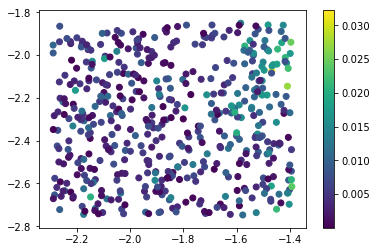

In [9]:
plt.scatter(param[:,0],param[:,1],c=err)
plt.colorbar()

## New testing of dataset

In [ ]:
# USING 1 SIGMA 
widths = [1,2,3,4,4.3]
width = widths[0]
np.load('SingleElement/'+str(width)+')